In [3]:
import pathlib
import pandas as pd
from scipy import sparse
from sklearn.preprocessing import normalize
import numpy as np
import pickle
from itertools import islice
import gzip
#from prompter import Prompter
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
#import scikit_posthocs as sp
import textwrap
import matplotlib.colors as mcolors
from sklearn.metrics import hamming_loss
pd.set_option('future.no_silent_downcasting', True)

In [4]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Retrieval

In [499]:
annotations_keep = pd.read_parquet("GENERATIONS/outs_good_model_tpc15/relevant_check/questions_topic_15_gpt-4o-2024-08-06_100_seed_1234_results_model30tpc_thr__combined_to_retrieve_relevant.parquet")
#annotations_keep = pd.read_parquet("GENERATIONS/outs_good_model_tpc15/relevant_check/questions_topic_15_qwen:32b_100_seed_1234_results_model30tpc_thr__combined_to_retrieve_relevant.parquet")
#annotations_keep = pd.read_parquet("GENERATIONS/outs_good_model_tpc15/relevant_check/questions_topic_15_llama3.3:70b_100_seed_1234_results_model30tpc_thr__combined_to_retrieve_relevant.parquet")
annotations_keep = annotations_keep[(annotations_keep["qwen2.5:7b-instruct"] == 1) & (annotations_keep["relevance_llama3:70b-instruct"] == 1) & (annotations_keep["relevance_llama3.1:8b-instruct-q8_0"] == 1)]
annotations_grouped = annotations_keep.groupby('question')['all_results'].apply(list).reset_index()
annotations_grouped = annotations_grouped.rename(columns = {"all_results": "relevant_docs"})
annotations_grouped["nr_relevant"] = annotations_grouped["relevant_docs"].apply(lambda x: len(x))
print(f"{annotations_grouped['nr_relevant'].mean():.3f}±{annotations_grouped['nr_relevant'].std():.3f}")

In [457]:
annotations_keep = annotations_keep[(annotations_keep["qwen2.5:7b-instruct"] == 1) & (annotations_keep["relevance_llama3:70b-instruct"] == 1) & (annotations_keep["relevance_llama3.1:8b-instruct-q8_0"] == 1)]
len(annotations_keep)

618

In [458]:
#annotations_keep[["question", "all_results_content"]]

In [459]:
annotations_grouped = annotations_keep.groupby('question')['all_results'].apply(list).reset_index()
annotations_grouped = annotations_grouped.rename(columns = {"all_results": "relevant_docs"})
annotations_grouped["nr_relevant"] = annotations_grouped["relevant_docs"].apply(lambda x: len(x))
print(f"{annotations_grouped['nr_relevant'].mean():.3f}±{annotations_grouped['nr_relevant'].std():.3f}")

4.612±4.818


## Explore recall

In [82]:
df_results = pd.read_excel("/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/src/qa_system/df_q_29jan_topic_15v2_es_model30tpc_thr__dynamic.xlsx")
#df_results = pd.read_excel("/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/src/qa_system/df_q_29jan_topic3_es_model10tpc.xlsx")
df_results = df_results.rename(columns={"questions": "question"})
df_results = df_results.merge(annotations_grouped, on="question")
df_results.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'pass_id', 'doc_id', 'passage',
       'full_doc', 'top_k', 'question', 'reason', 'question_id', 'queries',
       'results_1', 'results_2', 'results_3_weighted', 'results_3_unweighted',
       'results_4_weighted', 'results_4_unweighted', 'time_1', 'time_2',
       'time_3', 'time_4', 'theta_10', 'relevant_docs'],
      dtype='object')

In [ ]:
import ast

def extract_doc_ids(row, key):
    # Asegurar que el valor no está en un array de numpy
    try:
        if isinstance(row[key], np.ndarray):
            row[key] = row[key].tolist()  # Convertir a lista
        if isinstance(row[key], str):
            row_ = ast.literal_eval(row[key])
            return [el["doc_id"] for el in row_[0]]
        if isinstance(row[key], list) and len(row[key]) > 0:
            return [el["doc_id"] for el in row[key][0]]  # Acceder a la primera lista dentro
        #import pdb; pdb.set_trace()
    except:
        flattened_list = [{'doc_id': entry['doc_id'], 'score': entry['score']} for subarray in row[key] for entry in subarray]
        return [el["doc_id"] for el in flattened_list]
        
    return []
    
def precision_at_k(row, key, k=3):
    retrieved_docs = set(row[f"doc_ids_{key}"][:k])  
    relevant_docs = set(row["relevant_docs"])

    if not retrieved_docs:
        return 0.0

    return len(retrieved_docs & relevant_docs) / len(retrieved_docs)

def recall_at_k(row, key, k=3):
    retrieved_docs = set(row[f"doc_ids_{key}"][:k])
    relevant_docs = set(row["relevant_docs"])

    if not relevant_docs:
        return 0.0

    return len(retrieved_docs & relevant_docs) / len(relevant_docs)
    
def mean_reciprocal_rank(row, key):
    if isinstance(row[key], str):
        row_ = ast.literal_eval(row[key])
    else:
        row_ = row[key]

    try:
        retrieved_docs = [el["doc_id"] for el in row_[0]]
    except:
        flattened_list = [{'doc_id': entry['doc_id'], 'score': entry['score']} for subarray in row_ for entry in subarray]
        retrieved_docs = [el["doc_id"] for el in flattened_list]
        
    relevant_docs = set(row["relevant_docs"])
    
    for i, doc in enumerate(retrieved_docs):
        if doc in relevant_docs:
            return 1 / (i + 1)  # Reciprocal rank
    
    return 0  # No hay documentos relevantes en la lista


def multiple_mean_reciprocal_rank_at_k(row, key, k):
    retrieved_docs = row[f"doc_ids_{key}"][:k]
    relevant_docs = set(row["relevant_docs"])
    
    ranks = []
    for i, doc in enumerate(retrieved_docs):
        if doc in relevant_docs:
            ranks.append(i + 1)
    
    if not ranks:
        return 0

    numerator = np.mean(ranks)

    n = len(relevant_docs)
    denominator = (n / 2) + ((k + 1) * (n - len(ranks)))

    return numerator / denominator

def dcg_at_k(scores, k):
    return sum(rel / np.log2(idx + 2) for idx, rel in enumerate(scores[:k]))

def ndcg_at_k(row, key, k=10):
    retrieved_docs = row[f"doc_ids_{key}"][:k]
    relevant_docs = set(row["relevant_docs"])
    
    # 1 if the document is relevant, 0 otherwise
    gains = [1 if doc in relevant_docs else 0 for doc in retrieved_docs]
    
    dcg = dcg_at_k(gains, k)
    
    ideal_gains = sorted(gains, reverse=True)
    idcg = dcg_at_k(ideal_gains, k)
    
    return dcg / idcg if idcg > 0 else 0

k = 3
"""
for key in ["results_1", "results_2", "results_3_weighted", "results_3_unweighted",
            "results_4_weighted", "results_4_unweighted"]:
    df_results[f"doc_ids_{key}"] = df_results.apply(lambda x: extract_doc_ids(x, key), axis=1)
    df_results[f"precision_{key}"] = df_results.apply(lambda x: precision_at_k(x, key, k=k), axis=1)
    df_results[f"recall_{key}"] = df_results.apply(lambda x: recall_at_k(x, key, k=k), axis=1)
    df_results[f"mrr_{key}"] = df_results.apply(lambda x: mean_reciprocal_rank(x, key), axis=1)
    df_results[f"ndcg_{key}"] = df_results.apply(lambda x: ndcg_at_k(x, key, k=k), axis=1)
"""

'\nfor key in ["results_1", "results_2", "results_3_weighted", "results_3_unweighted",\n            "results_4_weighted", "results_4_unweighted"]:\n    df_results[f"doc_ids_{key}"] = df_results.apply(lambda x: extract_doc_ids(x, key), axis=1)\n    df_results[f"precision_{key}"] = df_results.apply(lambda x: precision_at_k(x, key, k=k), axis=1)\n    df_results[f"recall_{key}"] = df_results.apply(lambda x: recall_at_k(x, key, k=k), axis=1)\n    df_results[f"mrr_{key}"] = df_results.apply(lambda x: mean_reciprocal_rank(x, key), axis=1)\n    df_results[f"ndcg_{key}"] = df_results.apply(lambda x: ndcg_at_k(x, key, k=k), axis=1)\n'

In [114]:
df_results = pd.read_parquet("GENERATIONS/OLD_MODEL/relevant/questions_tpc15_llama3.3:70b_sample100_results_model30tpc_thr_.xlsx")
df_results = df_results.merge(annotations_grouped, on="question")
df_results["results_1_doc_ids"] = df_results.apply(lambda x: extract_doc_ids(x, key), axis=1)
df_results["mrr_results_1"] = df_results.apply(lambda x: mean_reciprocal_rank(x, key), axis=1)
df_results["mrr_results_1"]

0      0.125000
1      0.250000
2      0.000000
3      0.100000
4      0.166667
         ...   
218    0.000000
219    0.000000
220    1.000000
221    0.250000
222    1.000000
Name: mrr_results_1, Length: 223, dtype: float64

## For all files 

In [ ]:
########
k = 3 
########
# Paths to Excel files
excel_paths = [
    #"/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/src/qa_system/df_q_29jan_topic_15v2_es_model30tpc_thr__dynamic.xlsx",
    #"/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/src/qa_system/df_q_29jan_topic_15v2_es_model30tpc.xlsx",
    #"GENERATIONS/OLD_MODEL/relevant/questions_tpc15_llama3.3:70b_sample100_results_model30tpc_thr_.xlsx",
    #"GENERATIONS/OLD_MODEL/relevant/questions_tpc15_llama3.3:70b_sample100_results_model30tpc_thr__dynamic.parquet"
    #"GENERATIONS/OLD_MODEL/relevant/questions_tpc15_gpt-4o-2024-08-06_sample100_results_model30tpc_thr_.parquet",
    #"GENERATIONS/OLD_MODEL/relevant/questions_tpc15_gpt-4o-2024-08-06_sample100_results_model30tpc_thr__dynamic.parquet"   
    "GENERATIONS/outs_good_model_tpc15/relevant/questions_topic_15_gpt-4o-2024-08-06_100_seed_1234_results_model30tpc_thr_.parquet",
    "GENERATIONS/outs_good_model_tpc15/relevant/questions_topic_15_gpt-4o-2024-08-06_100_seed_1234_results_model30tpc_thr__dynamic.parquet"
]

# Define method names (ensuring Time is merged properly)
method_mapping = {
    "1": "ENN",
    "2": "ANN",
    "3_weighted": "TB-ENN-W",
    "3_unweighted": "TB-ENN",
    "4_weighted": "TB-ANN-W",
    "4_unweighted": "TB-ANN",
}

# Initialize DataFrame to store results across all files
all_results = []

# Read each Excel file and process results
for file_idx, path_results in enumerate(excel_paths):
    df_results = pd.read_parquet(path_results)
    df_results = df_results.drop_duplicates(subset=['question'], keep='first')
    df_results = df_results.rename(columns={"questions": "question"})
    df_results = df_results.merge(annotations_grouped, on="question")

        
    for key in ["results_1", "results_2", "results_3_weighted", "results_3_unweighted",
                "results_4_weighted", "results_4_unweighted"]:
        df_results[f"doc_ids_{key}"] = df_results.apply(lambda x: extract_doc_ids(x, key), axis=1)
        #import pdb; pdb.set_trace()
        #df_results[f"mrr_{key}"] = df_results.apply(lambda x: mean_reciprocal_rank(x, key), axis=1)
        
        for k in [3,5,10]:
            df_results[f"mrr_{k}_{key}"] = df_results.apply(lambda x: precision_at_k(x, key, k=k), axis=1)
            df_results[f"precision_{k}_{key}"] = df_results.apply(lambda x: precision_at_k(x, key, k=k), axis=1)
            df_results[f"recall_{k}_{key}"] = df_results.apply(lambda x: recall_at_k(x, key, k=k), axis=1)
            df_results[f"ndcg_{k}_{key}"] = df_results.apply(lambda x: ndcg_at_k(x, key, k=k), axis=1)
        #import pdb; pdb.set_trace()
        # **Ensure time values are stored once per method**
        df_results["time_3_weighted"] = df_results["time_3"]
        df_results["time_4_weighted"] = df_results["time_4"]
        df_results["time_3_unweighted"] = df_results["time_3"]
        df_results["time_4_unweighted"] = df_results["time_4"]

    # Select relevant columns
    keys_show = [col for col in df_results.columns if any(m in col for m in ["mrr_", "precision", "recall", "ndcg", "time"])]

    # Compute mean and standard deviation
    mean_values = df_results[keys_show].mean()
    std_values = df_results[keys_show].std()

    # Function to extract metric and method
    def extract_metric_method(metric):
        for key, value in method_mapping.items():
            if metric.endswith(f"_{key}") or f"_{key}_" in metric:
                base_metric = (
                    #"MRR" if "mrr_" in metric else
                    "MRR@3" if "mrr_3" in metric else
                    "MRR@5" if "mrr_5" in metric else
                    "MRR@10" if "mrr_10" in metric else
                    "NDCG@3" if "ndcg_3" in metric else
                    "NDCG@5" if "ndcg_5" in metric else
                    "NDCG@10" if "ndcg_10" in metric else
                    "Precision@3" if "precision_3" in metric else
                    "Precision@5" if "precision_5" in metric else
                    "Precision@10" if "precision_10" in metric else
                    "Recall@3" if "recall_3" in metric else
                    "Recall@5" if "recall_5" in metric else
                    "Recall@10" if "recall_10" in metric else
                    "Time (s)" if "time" in metric else
                    None
                )
                return base_metric, value  # Return (metric type, merged method)
        return None, metric  # Fallback

    # Create structured DataFrame for correct grouping
    data_entries = []
    time_values = {}  # Dictionary to store time values only once per method

    for col in mean_values.index:
        metric_type, method_name = extract_metric_method(col)
        if metric_type:
            mean, std = mean_values[col], std_values[col]

            # **Store Time values once per method**
            if metric_type == "Time (s)":
                time_values[method_name] = (mean, std)
            else:
                data_entries.append((file_idx, method_name, metric_type, mean, std))

    # **Ensure Time is added only once per method**
    for method, (mean, std) in time_values.items():
        data_entries.append((file_idx, method, "Time (s)", mean, std))
    # Convert into a properly structured DataFrame
    df_latex = pd.DataFrame(data_entries, columns=["FileID", "Method", "Metric", "Mean", "Std"])

    # **Drop duplicate time values (keep only one per method)**
    df_latex = df_latex.drop_duplicates(subset=["FileID", "Method", "Metric"], keep="first")

    # Store results for this Excel file
    all_results.append(df_latex)

# Concatenate results from all files (stacking new rows for each file)
df_latex = pd.concat(all_results)

# **🔹 Check unique metric names before pivoting**
print("Unique Metric Names in df_latex:", df_latex["Metric"].unique())  # Debugging Step

expected_metrics = ["NDCG@3", "NDCG@5","NDCG@10", "Precision@3", "Precision@5","Precision@10", "Recall@3", "Recall@5","Recall@10", "MRR", "Time (s)"]

# **Ensure best values are calculated per metric and file**
df_latex["BestValue"] = df_latex.groupby(["FileID", "Metric"])["Mean"].transform(lambda x: x.min() if "Time (s)" in x.name else x.max())

# Format mean ± std with bolding for best value within each file
def format_value(row):
    mean = f"{row['Mean']:.3f}"
    std = f"{row['Std']:.3f}"
    value = f"{mean} ± {std}"
    
    # **Bold only the best value within the same file and metric**
    if row["Mean"] == row["BestValue"]:  
        value = f"\\textbf{{{value}}}"
    
    return value

df_latex["Mean ± Std"] = df_latex.apply(format_value, axis=1)

# **Ensure 'Mean ± Std' exists now**
print("Columns in df_latex after formatting:", df_latex.columns)

# **Pivot table so that each Excel file contributes a unique row per method**
df_pivot = df_latex.pivot(index=["FileID", "Method"], columns="Metric", values="Mean ± Std")

# Ensure correct column order
df_pivot = df_pivot.reindex(columns=expected_metrics)

# Fix: Convert all values to strings and fill missing values
df_pivot = df_pivot.fillna("-").astype(str)  # Replace NaN with "-" and convert all values to strings

# Generate LaTeX table with grouped file blocks
# Generate LaTeX table with grouped file blocks
latex_output = "\\begin{table}[h]\n\\centering\n\\resizebox{\\textwidth}{!}{%\n\\begin{tabular}{lc" + "c" * len(df_pivot.columns) + "}\n\\arrayrulecolor{black}\n\\toprule\n"

# **Bold column headers**
latex_output += "File & \\textbf{Method} & " + " & ".join([f"\\textbf{{{col}}}" for col in df_pivot.columns]) + " \\\\\n\\midrule\n"

# **Loop through grouped rows and format output**
current_file_id = None  # Track when a new file starts
for (file_idx, method), row in df_pivot.iterrows():
    if file_idx != current_file_id:  
        # **Add a thin line above (only if it's not the first file)**
        if current_file_id is not None:
            latex_output += "\\arrayrulecolor{black}\\specialrule{0.5pt}{0pt}{0pt}\\arrayrulecolor{black}\n"
        
        # **Write File Title (without background)**
        latex_output += f"\\multicolumn{{{len(df_pivot.columns) + 2}}}{{l}}{{\\textbf{{File {file_idx+1}}}}} \\\\\n"
        
        # **Add a thin line below the file title**
        latex_output += "\\arrayrulecolor{black}\\specialrule{0.5pt}{0pt}{0pt}\\arrayrulecolor{black}\n"
        
        current_file_id = file_idx  
    
    # **Apply row coloring for TB-ANN**
    row_start = "\\rowcolor{tableblue} " if method == "XX" else ""
    
    # **Bold method names**
    latex_output += row_start + f"& \\textbf{{{method}}} & " + " & ".join(row.astype(str)) + " \\\\\n"

latex_output += "\\bottomrule\n\\end{tabular}}\n\\caption{Performance Metrics per Method for Each File (Best values in bold)}\n\\label{tab:grouped_results}\n\\end{table}"

print("#########\n")
# Save or print LaTeX table
with open("results_transposed_table.tex", "w") as f:
    f.write(latex_output)

print(latex_output)

In [648]:
annotations_keep = pd.read_parquet(method_tuple[0])
annotations_keep_qwen = pd.read_parquet(method_tuple[0].replace(".parquet", "_qwen_added.parquet"))
len(annotations_keep_qwen[annotations_keep_qwen['relevance_qwen2.5:7b-instruct'] == 1])

446

## WEIGTHED

In [ ]:
########
k = 3
tpc = 11
########
# Paths to Excel files
excel_paths = [  
    (f"GENERATIONS/outs_good_model_tpc{tpc}/relevant_check/questions_topic_{tpc}_qwen:32b_100_seed_1234_results_model30tpc_thr__combined_to_retrieve_relevant.parquet",
        [
            f"GENERATIONS/outs_good_model_tpc{tpc}/relevant/questions_topic_{tpc}_qwen:32b_100_seed_1234_results_model30tpc_thr_.parquet",
            f"GENERATIONS/outs_good_model_tpc{tpc}/relevant/questions_topic_{tpc}_qwen:32b_100_seed_1234_results_model30tpc_thr__dynamic.parquet"
        ]    
    ),
    (f"GENERATIONS/outs_good_model_tpc{tpc}/relevant_check/questions_topic_{tpc}_llama3.3:70b_100_seed_1234_results_model30tpc_thr__combined_to_retrieve_relevant.parquet",
        [
            f"GENERATIONS/outs_good_model_tpc{tpc}/relevant/questions_topic_{tpc}_llama3.3:70b_100_seed_1234_results_model30tpc_thr_.parquet",
            f"GENERATIONS/outs_good_model_tpc{tpc}/relevant/questions_topic_{tpc}_llama3.3:70b_100_seed_1234_results_model30tpc_thr_.parquet",
        ]    
    ),
    (f"GENERATIONS/outs_good_model_tpc{tpc}/relevant_check/questions_topic_{tpc}_gpt-4o-2024-08-06_100_seed_1234_results_model30tpc_thr__combined_to_retrieve_relevant.parquet",
        [
            f"GENERATIONS/outs_good_model_tpc{tpc}/relevant/questions_topic_{tpc}_gpt-4o-2024-08-06_100_seed_1234_results_model30tpc_thr_.parquet",
            f"GENERATIONS/outs_good_model_tpc{tpc}/relevant/questions_topic_{tpc}_gpt-4o-2024-08-06_100_seed_1234_results_model30tpc_thr__dynamic.parquet"]
    ),
]

# Ensure method mapping is correctly defined
method_mapping = {
        "1": "ENN",
        "2": "ANN",
        "3_weighted": "TB-ENN-W",
        "3_unweighted": "TB-ENN",
        "4_weighted": "TB-ANN-W",
        "4_unweighted": "TB-ANN",
        "time_1": "ENN",
        "time_2": "ANN",
        "time_3_weighted": "TB-ENN-W",
        "time_3_unweighted": "TB-ENN",
        "time_4_weighted": "TB-ANN-W",
        "time_4_unweighted": "TB-ANN",
        
}

def extract_metric_method(metric):
    for key, value in method_mapping.items():
        if metric.endswith(f"_{key}") or f"_{key}_" in metric:
            base_metric = (
                #"MRR" if "mrr_" in metric else
                "MRR@3" if "mrr_3" in metric else
                "MRR@5" if "mrr_5" in metric else
                "MRR@10" if "mrr_10" in metric else
                "NDCG@3" if "ndcg_3" in metric else
                "NDCG@5" if "ndcg_5" in metric else
                "NDCG@10" if "ndcg_10" in metric else
                "Precision@3" if "precision_3" in metric else
                "Precision@5" if "precision_5" in metric else
                "Precision@10" if "precision_10" in metric else
                "Recall@3" if "recall_3" in metric else
                "Recall@5" if "recall_5" in metric else
                "Recall@10" if "recall_10" in metric else
                "Time (s)" if "time" in metric else
                None
            )
            return base_metric, value  # Return (metric type, merged method)
    return None, metric  # Fallback

# Extract the number of relevant passages for each query
#annotations_grouped["num_relevant_docs"] = annotations_grouped["relevant_docs"].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Define the retrieval metrics to compute weighted means for
retrieval_metrics = [
    "mrr_3", "mrr_5",
    #"mrr_10", 
    "precision_3", "precision_5", 
    #"precision_10",
    "recall_3", "recall_5", 
    #"recall_10", 
    "ndcg_3", "ndcg_5", 
    #"ndcg_10"
]

# Read and process results from all files
methods = ["QWEN", "LLAMA", "GPT"] 
for id_method, method_tuple in enumerate(excel_paths):
    print(f"\n***** {methods[id_method]} *****\n")

    annotations_keep = pd.read_parquet(method_tuple[0].replace(".parquet", "_all_added.parquet"))
    #annotations_keep = pd.read_parquet(method_tuple[0].replace(".parquet", "_qwen_added.parquet"))
    annotations_keep = annotations_keep[(annotations_keep["relevance_llama3.3:70b"] == 1) & (annotations_keep["relevance_qwen:32b"] == 1) & (annotations_keep["relevance_llama3:70b-instruct"] == 1) & (annotations_keep["relevance_llama3.1:8b-instruct-q8_0"] == 1)]# 
    annotations_grouped = annotations_keep.groupby('question')['all_results'].apply(list).reset_index()
    annotations_grouped = annotations_grouped.rename(columns = {"all_results": "relevant_docs"})
    annotations_grouped["num_relevant_docs"] = annotations_grouped["relevant_docs"].apply(lambda x: len(x))
    print(f"Number of relevant passages for {methods[id_method]}: {annotations_grouped['num_relevant_docs'].mean():.3f}±{annotations_grouped['num_relevant_docs'].std():.3f}")

    weighted_results = []
    for file_idx, path_results in enumerate(method_tuple[1]):
        df_results = pd.read_parquet(path_results)
        df_results = df_results.drop_duplicates(subset=['question'], keep='first')
        df_results = df_results.rename(columns={"questions": "question"})
        df_results = df_results.merge(annotations_grouped, on="question")
    
        for key in ["results_1", "results_2", "results_3_weighted", "results_3_unweighted",
                    "results_4_weighted", "results_4_unweighted"]:
            
            df_results[f"doc_ids_{key}"] = df_results.apply(lambda x: extract_doc_ids(x, key), axis=1)
            for k in [3,5,10]:
                #import pdb; pdb.set_trace()
                df_results[f"mrr_{k}_{key}"] = df_results.apply(lambda x: multiple_mean_reciprocal_rank_at_k(x, key, k=k), axis=1)
                df_results[f"precision_{k}_{key}"] = df_results.apply(lambda x: precision_at_k(x, key, k=k), axis=1)
                df_results[f"recall_{k}_{key}"] = df_results.apply(lambda x: recall_at_k(x, key, k=k), axis=1)
                df_results[f"ndcg_{k}_{key}"] = df_results.apply(lambda x: ndcg_at_k(x, key, k=k), axis=1)

            df_results["time_3_weighted"] = df_results["time_3"]
            df_results["time_4_weighted"] = df_results["time_4"]
            df_results["time_3_unweighted"] = df_results["time_3"]
            df_results["time_4_unweighted"] = df_results["time_4"]
            
            method_name = method_mapping.get(key, key)

            print(f"Calculating for retrieval metrics: {retrieval_metrics}")
            for metric in retrieval_metrics:
                metric_column = f"{metric}_{key}"
    
                if metric_column in df_results.columns:
                    values = df_results[metric_column].dropna()
                    weights = df_results.loc[values.index, "num_relevant_docs"].fillna(1)
    
                    weighted_mean = np.average(values, weights=weights)
                    weighted_var = np.average((values - weighted_mean) ** 2, weights=weights)
                    weighted_std = np.sqrt(weighted_var)
                    n = len(values)
                    ci = 1.96 * (weighted_std / np.sqrt(n)) if n > 1 else 0
    
                    metric_name, method_display = extract_metric_method(metric_column)
                    weighted_results.append((file_idx, method_display, metric_name, weighted_mean, ci))

            print("Calcualting for time")
            # do the same for the time
            metric = "time"
            key_for_time = key.split("results_")[-1]
            #print(key_for_time)
            metric_column = f"{metric}_{key_for_time}"
            #print(metric_column)
            values = df_results[metric_column].dropna()
            mean_values = values.mean()
            std_values = values.std()
            metric_name, method_display = extract_metric_method(metric_column)
            #print(f"Key for time {metric_name}, {method_display}")
            weighted_results.append((file_idx, method_display, metric_name, mean_values, std_values))
    
    # Convert results into a structured DataFrame
    df_weighted = pd.DataFrame(weighted_results, columns=["FileID", "Method", "Metric", "Weighted Mean", "95% CI"])
    
    df_weighted["BestValue"] = df_weighted.groupby(["FileID", "Metric"])["Weighted Mean"].transform(
        lambda x: x.min() if "Time (s)" in x.name else x.max()
    )
    
    """
    def format_weighted_value(row):
        mean = f"{row['Weighted Mean']:.3f}"
        ci = f"{row['95% CI']:.3f}"
        value = f"{mean} ± {ci}"
        if row["Weighted Mean"] == row["BestValue"]:
            value = f"\\textbf{{{value}}}"
        return value
    #df_weighted["Weighted Mean ± CI"] = df_weighted.apply(format_weighted_value, axis=1)
    """
    
    #### SIGNIFICANCE TESTS #####
    # Define function to add significance markers based on p-values
    def get_significance_marker(p_value):
        if p_value < 0.001:
            return "***"
        elif p_value < 0.01:
            return "**"
        elif p_value < 0.05:
            return "*"
        else:
            return ""
    
    # Modify format function to add significance markers
    def format_weighted_value(row):
        mean = f"{row['Weighted Mean']:.3f}"
        ci = f"{row['95% CI']:.3f}"
        value = f"{mean} \pm {ci}"
    
        metric = row["Metric"]
        method = row["Method"]
    
        """
        # Agregar '*' si Kruskal-Wallis indica diferencias significativas
        if metric in significance_dict["Kruskal-Wallis p-value"]:
            kw_p_value = significance_dict["Kruskal-Wallis p-value"][metric]
            if kw_p_value < 0.05:
                value += " *"  # Indica que hay diferencias globales
        """
        significance_marker = ""
        if metric in significance_dict["Significant post-hoc tests (Dunn)"]:
            dunn_df = significance_dict["Significant post-hoc tests (Dunn)"][metric]
            for other_method in dunn_df.index:
                if method in dunn_df.columns and other_method in dunn_df.index:
                    p_val = dunn_df.loc[other_method, method]
                    if p_val < 0.001:
                        significance_marker = "***"
                    elif p_val < 0.01:
                        significance_marker = "**"
                    elif p_val < 0.05:
                        significance_marker = "*"
    
        value += f"^{{{significance_marker}}}"
    
        if row["Weighted Mean"] == row["BestValue"]:
            return f"\\(\\boldsymbol{{{value}}}\\)"
        else:
            return f"\\({value}\\)"
            
    def format_metric(metric):
        return (
                "MRR@3" if metric == "mrr_3" else
                "MRR@5" if metric == "mrr_5" else
                "NDCG@3" if metric == "ndcg_3" else
                "NDCG@5" if metric == "ndcg_5" else
                "Precision@3" if metric == "precision_3" else
                "Precision@5" if metric == "precision_5" else
                "Recall@3" if metric == "recall_3" else
                "Recall@5" if metric == "recall_5" else
                "Time (s)" if "time" in metric else
                metric  # Fallback si no está en la lista
            )
    
    #### TO CALCULATE SIGNIFICANCE TESTS
    df_columns_keep = [col for col in df_results.columns if any(metric in col for metric in retrieval_metrics + ["time"])]
    #print(df_columns_keep)
    
    metric_columns = [col for col in df_results[df_columns_keep].columns if ("results_" in col or "time" in col) and ("time_3" not in col and "time_4" not in col)]
    df_long = df_results.melt(value_vars=metric_columns, var_name="Metric", value_name="Value")
    
    df_long["Method"] = df_long["Metric"].apply(lambda x: method_mapping[x.split("_results_")[-1]])
    df_long["Metric"] = df_long["Metric"].apply(lambda x: format_metric(x.split("_results_")[0]))
    
    # Check normality
    normality_tests = {}
    for metric in df_long["Metric"].unique():
        for method in df_long["Method"].unique():
            values = df_long[(df_long["Metric"] == metric) & (df_long["Method"] == method)]["Value"]
            if len(values) > 3:  # Shapiro necesita al menos unos pocos valores
                stat, p_value = stats.shapiro(values)
                normality_tests[(metric, method)] = p_value
    
    # ANOVA or Kruskal-Wallis
    anova_results = {}
    kruskal_results = {}
    
    for metric in df_long["Metric"].unique():
        groups = [df_long[(df_long["Metric"] == metric) & (df_long["Method"] == method)]["Value"].dropna() for method in df_long["Method"].unique()]
        # if normality in at least one group
        normal = all(p > 0.05 for p in [normality_tests.get((metric, method), 0) for method in df_long["Method"].unique()])
        
        if normal:
            stat, p_value = stats.f_oneway(*groups)
            anova_results[metric] = p_value
        else:
            stat, p_value = stats.kruskal(*groups)
            kruskal_results[metric] = p_value
    
    # post-hoc tests if Kruskal-Wallis is significant
    posthoc_results = {}
    for metric, p in kruskal_results.items():
        if p < 0.05:  # Si hay diferencias significativas
            df_filtered = df_long[df_long["Metric"] == metric]
            posthoc = sp.posthoc_dunn(df_filtered, val_col="Value", group_col="Method", p_adjust="bonferroni")
            posthoc_results[metric] = posthoc
    
    significance_dict = {
        "ANOVA p-value": anova_results,
        "Kruskal-Wallis p-value": kruskal_results,
        "Significant post-hoc tests (Dunn)": posthoc_results
    }
    
    df_weighted["Weighted Mean ± CI"] = df_weighted.apply(format_weighted_value, axis=1)
    
    df_weighted_pivot = df_weighted.pivot(index=["FileID", "Method"], columns="Metric", values="Weighted Mean ± CI")
    
    latex_output = "\\begin{table*}[h]\n\\centering\n\\resizebox{\\textwidth}{!}{%\n\\begin{tabular}{lc" + "c" * len(df_weighted_pivot.columns) + "}\n\\arrayrulecolor{black}\n\\toprule\n"
    
    latex_output += "File & \\textbf{Method} & " + " & ".join([f"\\textbf{{{col}}}" for col in df_weighted_pivot.columns]) + " \\\\\n\\midrule\n"
    
    current_file_id = None 
    for (file_idx, method), row in df_weighted_pivot.iterrows():
        if file_idx != current_file_id:  
            if current_file_id is not None:
                latex_output += "\\arrayrulecolor{black}\\specialrule{0.5pt}{0pt}{0pt}\\arrayrulecolor{black}\n"
            
            latex_output += f"\\multicolumn{{{len(df_weighted_pivot.columns) + 2}}}{{l}}{{\\textbf{{File {file_idx+1}}}}} \\\\\n"
            
            latex_output += "\\arrayrulecolor{black}\\specialrule{0.5pt}{0pt}{0pt}\\arrayrulecolor{black}\n"
            
            current_file_id = file_idx  
        
        row_start = "\\rowcolor{tableblue} " if method == "XX" else ""
        
        latex_output += row_start + f"& \\textbf{{{method}}} & " + " & ".join(row.astype(str)) + " \\\\\n"
    
    latex_output += "\\bottomrule\n\\end{tabular}}\n\\caption{Performance Metrics per Method for Each File (Best values in bold)}\n\\label{tab:grouped_results}\n\\end{table*}"
    
    print(latex_output)


***** QWEN *****

Number of relevant passages for QWEN: 4.506±4.503
Calculating for retrieval metrics: ['mrr_3', 'mrr_5', 'precision_3', 'precision_5', 'recall_3', 'recall_5', 'ndcg_3', 'ndcg_5']
Calcualting for time
Calculating for retrieval metrics: ['mrr_3', 'mrr_5', 'precision_3', 'precision_5', 'recall_3', 'recall_5', 'ndcg_3', 'ndcg_5']
Calcualting for time
Calculating for retrieval metrics: ['mrr_3', 'mrr_5', 'precision_3', 'precision_5', 'recall_3', 'recall_5', 'ndcg_3', 'ndcg_5']
Calcualting for time
Calculating for retrieval metrics: ['mrr_3', 'mrr_5', 'precision_3', 'precision_5', 'recall_3', 'recall_5', 'ndcg_3', 'ndcg_5']
Calcualting for time
Calculating for retrieval metrics: ['mrr_3', 'mrr_5', 'precision_3', 'precision_5', 'recall_3', 'recall_5', 'ndcg_3', 'ndcg_5']
Calcualting for time
Calculating for retrieval metrics: ['mrr_3', 'mrr_5', 'precision_3', 'precision_5', 'recall_3', 'recall_5', 'ndcg_3', 'ndcg_5']
Calcualting for time
Calculating for retrieval metrics: ['

In [392]:
#### TO CALCULATE SINGICANCAE TESTS
df_columns_keep = [col for col in df_results.columns if any(metric in col for metric in retrieval_metrics + ["time"])]
#print(df_columns_keep)

metric_columns = [col for col in df_results[df_columns_keep].columns if ("results_" in col or "time" in col) and ("time_3" not in col and "time_4" not in col)]
df_long = df_results.melt(value_vars=metric_columns, var_name="Metric", value_name="Value")

df_long["Method"] = df_long["Metric"].apply(lambda x: method_mapping[x.split("_results_")[-1]])
df_long["Metric"] = df_long["Metric"].apply(lambda x: format_metric(x.split("_results_")[0]))

# Verificar si los datos siguen una distribución normal con Shapiro-Wilk
normality_tests = {}
for metric in df_long["Metric"].unique():
    for method in df_long["Method"].unique():
        values = df_long[(df_long["Metric"] == metric) & (df_long["Method"] == method)]["Value"]
        if len(values) > 3:  # Shapiro necesita al menos unos pocos valores
            stat, p_value = stats.shapiro(values)
            normality_tests[(metric, method)] = p_value

# Determinar si aplicar ANOVA o Kruskal-Wallis
anova_results = {}
kruskal_results = {}

for metric in df_long["Metric"].unique():
    groups = [df_long[(df_long["Metric"] == metric) & (df_long["Method"] == method)]["Value"].dropna() for method in df_long["Method"].unique()]
    # Revisamos si los datos son normales en al menos un método
    normal = all(p > 0.05 for p in [normality_tests.get((metric, method), 0) for method in df_long["Method"].unique()])
    
    if normal:
        # Aplicamos ANOVA
        stat, p_value = stats.f_oneway(*groups)
        anova_results[metric] = p_value
    else:
        # Aplicamos Kruskal-Wallis
        stat, p_value = stats.kruskal(*groups)
        kruskal_results[metric] = p_value

# Pruebas post-hoc si Kruskal-Wallis es significativo
posthoc_results = {}
for metric, p in kruskal_results.items():
    if p < 0.05:  # Si hay diferencias significativas
        df_filtered = df_long[df_long["Metric"] == metric]
        posthoc = sp.posthoc_dunn(df_filtered, val_col="Value", group_col="Method", p_adjust="bonferroni")
        posthoc_results[metric] = posthoc

# Mostrar resultados
significance_dict = {
    "ANOVA p-value": anova_results,
    "Kruskal-Wallis p-value": kruskal_results,
    "Significant post-hoc tests (Dunn)": posthoc_results
}
significance_dict

{'ANOVA p-value': {},
 'Kruskal-Wallis p-value': {'Time (s)': nan,
  'MRR@3': 0.016975001568797422,
  'Precision@3': 0.05655674026230099,
  'Recall@3': 0.017679620820012763,
  'NDCG@3': 0.12271388322063023,
  'MRR@5': 0.0013617240535995572,
  'Precision@5': 0.02708638857402505,
  'Recall@5': 0.0030869274285479703,
  'NDCG@5': 0.04953672925808516},
 'Significant post-hoc tests (Dunn)': {'MRR@3':                ANN       ENN  TB-ANN  TB-ANN-W    TB-ENN  TB-ENN-W
  ANN       1.000000  0.361384     1.0  1.000000  0.237643  0.182056
  ENN       0.361384  1.000000     1.0  0.466626  1.000000  1.000000
  TB-ANN    1.000000  1.000000     1.0  1.000000  1.000000  1.000000
  TB-ANN-W  1.000000  0.466626     1.0  1.000000  0.311215  0.240496
  TB-ENN    0.237643  1.000000     1.0  0.311215  1.000000  1.000000
  TB-ENN-W  0.182056  1.000000     1.0  0.240496  1.000000  1.000000,
  'Recall@3':                ANN       ENN  TB-ANN  TB-ANN-W    TB-ENN  TB-ENN-W
  ANN       1.000000  0.304674     1.0 

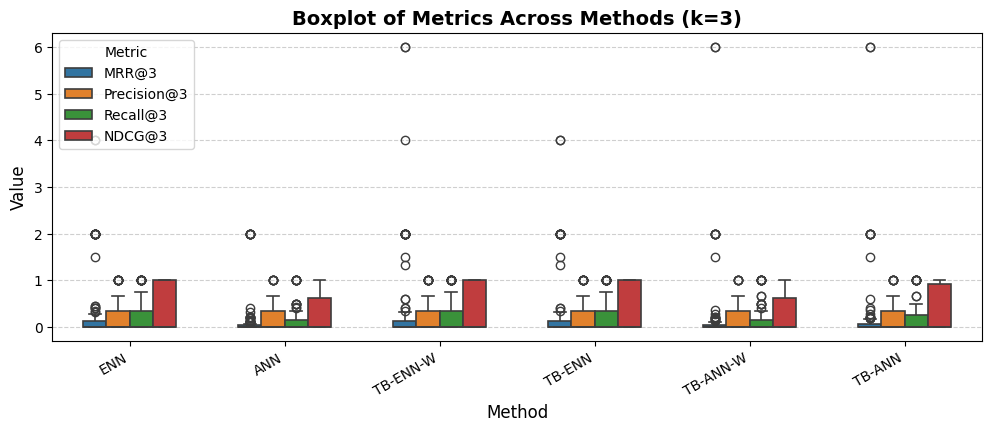

In [317]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter only the relevant metrics
metrics = ["MRR@3", "Precision@3", "Recall@3", "NDCG@3"]
df_long_filtered = df_long[df_long["Metric"].isin(metrics)]

# Set figure size with reduced height
plt.figure(figsize=(12, 4))  # Reduce height from 6 to 4

# Create a single boxplot with improved aesthetics
sns.boxplot(x="Method", y="Value", hue="Metric", data=df_long_filtered, 
            showfliers=True, width=0.6, linewidth=1.2)

plt.xticks(rotation=30, ha="right")  # Improve readability
plt.title("Boxplot of Metrics Across Methods (k=3)", fontsize=14, fontweight="bold")
plt.ylabel("Value", fontsize=12)
plt.xlabel("Method", fontsize=12)
plt.legend(title="Metric", loc="upper left", fontsize=10)

# Improve grid aesthetics
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Show the updated plot
plt.show()

# Question Generation Quality

In [429]:
# Convert to DataFrame
df_models = pd.read_excel("GENERATIONS/OLD_MODEL/questions_queries_annotate/annotated/annotate_tpc_15_old_pat.xlsx")
criteria_columns = ["Verifiability", "Passage Independence", "Clarity", "Terminology", "Self-Containment", "Naturalness"]

aux = df_models.groupby("model")[criteria_columns].mean() * 100
df_transformed = aux.T  # Transpose the dataframe
df_transformed.columns.name = None  # Remove the name of the columns

In [427]:
plt.rcdefaults()

In [ ]:
# Convert to DataFrame
df_models = pd.read_excel("GENERATIONS/OLD_MODEL/questions_queries_annotate/annotated/annotate_tpc_15_old_pat.xlsx")
criteria_columns = ["Verifiability", "Passage Independence", "Clarity", "Terminology", "Self-Containment", "Naturalness"]

aux = df_models.groupby("model")[criteria_columns].mean() * 100
df_models = aux.T  # Transpose the dataframe
df_models.columns.name = None  # Remove the name of the columns
df_models = df_models.rename(columns={"gpt-4o-2024-08-06":"gpt-4-o"})

# Define colorblind-friendly Tableau 10 palette
colorblind_palette_ = plt.get_cmap("tab10")  
colorblind_palette = [colorblind_palette_(i) for i in range(len(models))]

## **Fix 1: Increase figure width dynamically**
fig, ax = plt.subplots(figsize=(max(9, 3 + len(models) * 1.5), 3), dpi=300)  # Adjust width based on model count

## **Fix 2: Reduce bar width dynamically**
bar_width = max(0.15, 0.8 / len(models))  # Ensures bars don’t overlap
x = np.arange(len(criteria_columns))  # X locations for groups

# Plot each model's data using the colorblind palette
bars = []
for i, (model, color) in enumerate(zip(models, colorblind_palette)):
    bars.append(ax.bar(x + i * bar_width, df_models[model], width=bar_width, label=model, color=color, edgecolor="black"))

# Labels and title
ax.set_xlabel("Evaluation Criteria", fontsize=13, fontweight="bold", color="black")

## **Fix 3: Make y-label more concise**
ax.set_ylabel("Criteria\nFulfillment (%)", fontsize=13, fontweight="bold", color="black", labelpad=6)

## **Fix 4: Center x-axis labels properly**
ax.set_xticks(x + bar_width * (len(models) / 2))  # Adjust centering based on the number of models

# Adjust criteria labels for readability (split long labels into two lines if needed)
formatted_labels = [textwrap.fill(label, width=13) for label in criteria_columns]  # Wrap at ~12 characters
ax.set_xticklabels(formatted_labels, fontsize=11, color="black", ha="center")

ax.set_ylim(0, 104)  # Percentage scale
ax.tick_params(axis="y", labelcolor="black", labelsize=11)
ax.tick_params(axis="x", labelcolor="black", labelsize=11)
ax.grid(True, linestyle="--", alpha=0.5)

# Make x and y axis borders black
for spine in ax.spines.values():
    spine.set_color("black")

## **Fix 5: Increase bottom margin for labels & legend**
fig.subplots_adjust(bottom=0.4)  # Extra space for readability

# Move legend outside the plot (below) in a single line
legend = fig.legend(fontsize=11, loc="lower center", frameon=True, ncol=len(models), bbox_to_anchor=(0.5, 0))
legend.get_frame().set_edgecolor("black")

# Save as high-resolution PDF
plt.savefig("question_quality_evaluation.pdf", dpi=300, bbox_inches="tight")

# Show the figure
plt.show()

## 2 annotators 

In [431]:
df_annotator2 = pd.read_excel("GENERATIONS/OLD_MODEL/questions_queries_annotate/annotated/annotate_tpc_15_new - Cannibal Teddy.xlsx")
df_annotator2[df_annotator2.isnull().any(axis=1)]

,Unnamed: 0,question_id,passage,question,Verifiability,Passage Independence,Clarity,Terminology,Self-Containment,Naturalness,model
53,53,0,"For migraine with aura, some questions to ask your doctor include:\n- What's the likely cause of my symptoms?\n- What tests, if any, do I need?\n- Is my condition likely temporary or chronic?\n- What treatments are available? Which do you recommend?\n- I have other health conditions. How can I best manage them together?\n- Are there dietary restrictions I need to follow?\n- Are there written materials I can take with me or websites you recommend?.","Can a doctor diagnose migraine with aura based on signs and symptoms, medical and family history, and a physical exam?",1,NaN,NaN,NaN,NaN,NaN,llama3.3:70b


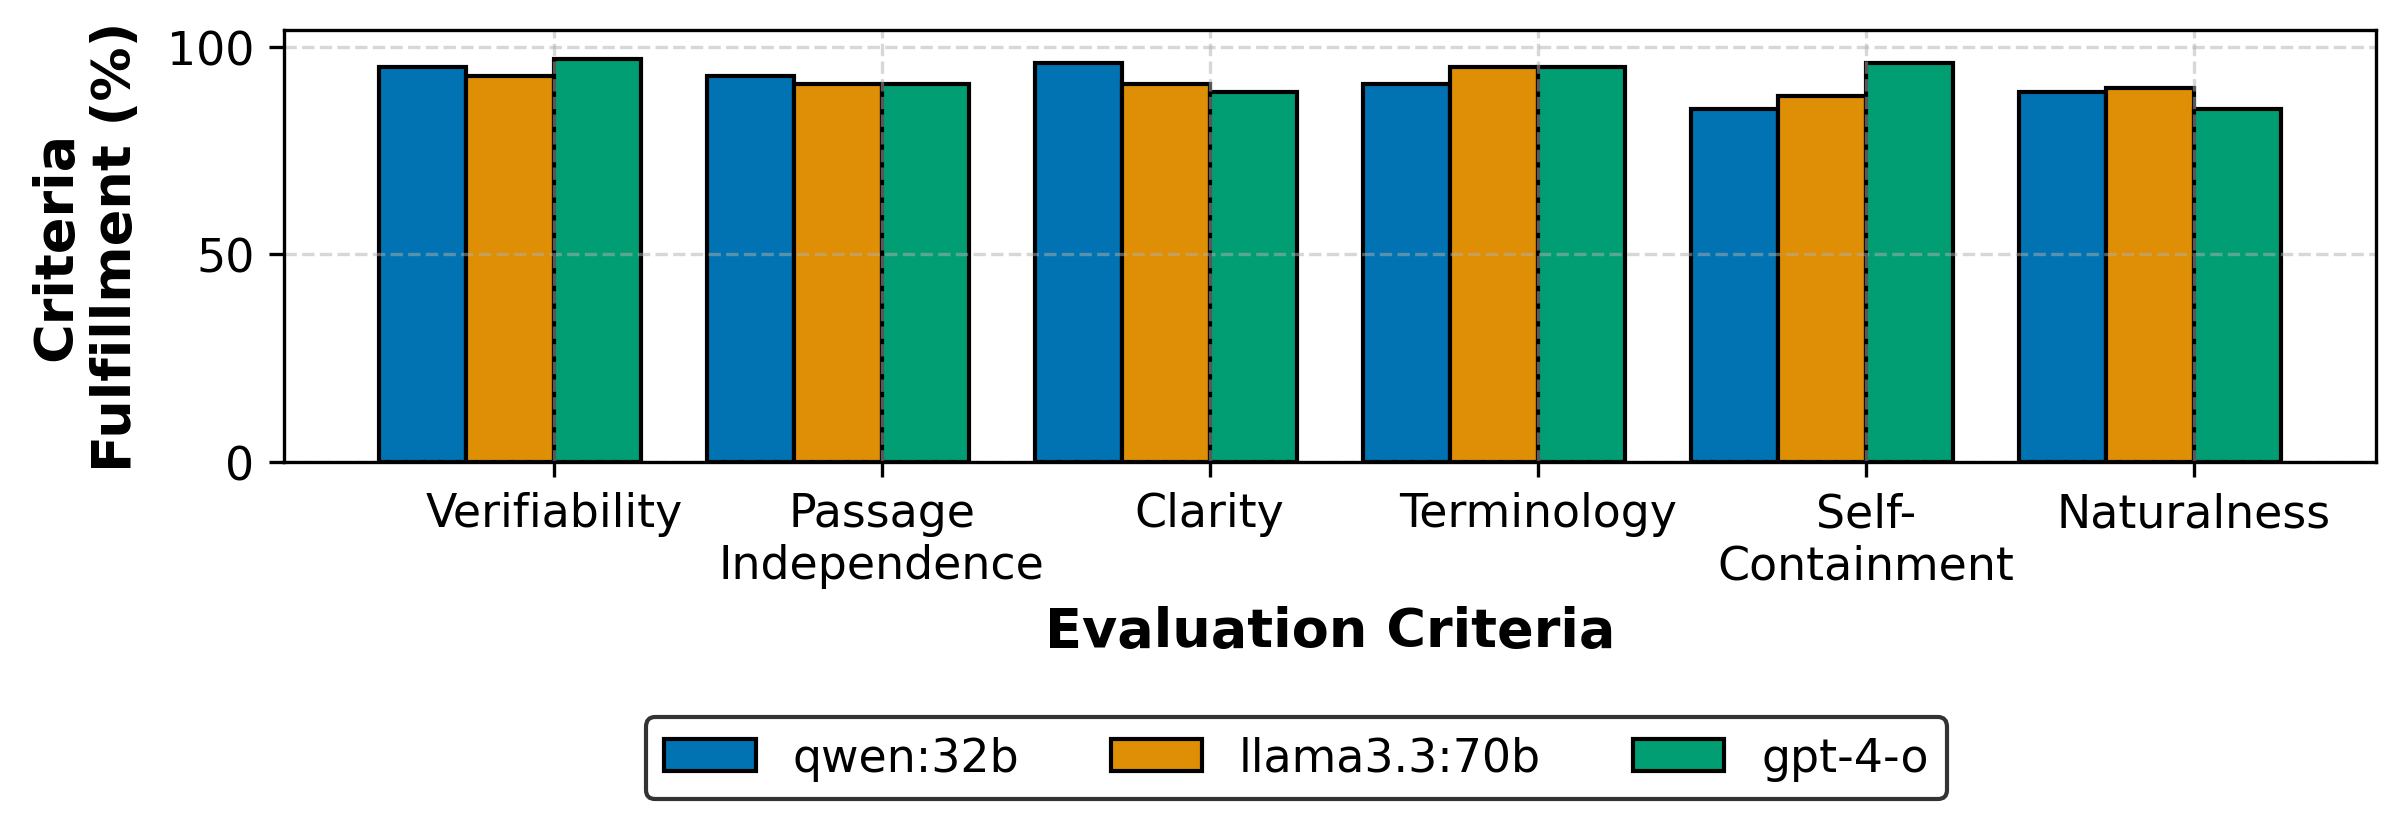

In [435]:
# Cargar las anotaciones de ambos anotadores
df_annotator1 = pd.read_excel("GENERATIONS/OLD_MODEL/questions_queries_annotate/annotated/annotate_tpc_15_old_pat.xlsx")
df_annotator2 = pd.read_excel("GENERATIONS/OLD_MODEL/questions_queries_annotate/annotated/annotate_tpc_15_new - Cannibal Teddy.xlsx").fillna(0)

# Definir las columnas de criterios
criteria_columns = ["Verifiability", "Passage Independence", "Clarity", "Terminology", "Self-Containment", "Naturalness"]

# Fusionar los DataFrames por pregunta y modelo
df_combined = df_annotator1.merge(df_annotator2, on=["question_id", "model"], suffixes=("_a1", "_a2"))

# Calcular el promedio por pregunta entre los dos anotadores
for col in criteria_columns:
    df_combined[col] = df_combined[[f"{col}_a1", f"{col}_a2"]].mean(axis=1)

# Agrupar por modelo y calcular el promedio final
df_models = df_combined.groupby("model")[criteria_columns].mean() * 100
df_models = df_models.T  # Transponer para mejor visualización
df_models.columns.name = None  # Quitar nombre de las columnas
df_models = df_models.rename(columns={"gpt-4o-2024-08-06": "gpt-4-o"})

# Reorder df_models columns
desired_order = ["qwen:32b", "llama3.3:70b", "gpt-4-o"]
df_models = df_models[desired_order]

# Configuración del gráfico
models = df_models.columns
colorblind_palette = sns.color_palette("colorblind", len(models))
#colorblind_palette = [colorblind_palette_(i) for i in range(len(models))]

fig, ax = plt.subplots(figsize=(max(9, 3 + len(models) * 1.5), 3), dpi=300)
bar_width = max(0.15, 0.8 / len(models))  # Ajusta el ancho de las barras dinámicamente
x = np.arange(len(criteria_columns))

bars = []
for i, (model, color) in enumerate(zip(models, colorblind_palette)):
    bars.append(ax.bar(x + i * bar_width, df_models[model], width=bar_width, label=model, color=color, edgecolor="black"))

# Etiquetas y formato
ax.set_xlabel("Evaluation Criteria", fontsize=13, fontweight="bold", color="black")
ax.set_ylabel("Criteria\nFulfillment (%)", fontsize=13, fontweight="bold", color="black", labelpad=6)
ax.set_xticks(x + bar_width * (len(models) / 2))  

formatted_labels = [textwrap.fill(label, width=13) for label in criteria_columns]
ax.set_xticklabels(formatted_labels, fontsize=11, color="black", ha="center")

ax.set_ylim(0, 104)
ax.tick_params(axis="y", labelcolor="black", labelsize=11)
ax.tick_params(axis="x", labelcolor="black", labelsize=11)
ax.grid(True, linestyle="--", alpha=0.5)

for spine in ax.spines.values():
    spine.set_color("black")

fig.subplots_adjust(bottom=0.4)

legend = fig.legend(fontsize=11, loc="lower center", frameon=True, ncol=len(models), bbox_to_anchor=(0.5, 0))
legend.get_frame().set_edgecolor("black")

plt.savefig("/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/figures/question_quality_evaluation.pdf", dpi=300, bbox_inches="tight")
plt.show()


In [681]:
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score

df_combined = df_annotator1.merge(df_annotator2, on=["question_id", "model"], suffixes=("_a1", "_a2"))

# Calcular Cohen's Kappa para cada criterio
kappa_scores = {col: cohen_kappa_score(df_combined[f"{col}_a1"], df_combined[f"{col}_a2"]) for col in criteria_columns}

# Mostrar resultados
df_kappa = pd.DataFrame.from_dict(kappa_scores, orient="index", columns=["Cohen's Kappa"])
df_kappa

,Cohen's Kappa
Verifiability,0.249318
Passage Independence,0.138874
Clarity,0.145786
Terminology,0.169742
Self-Containment,0.259520
Naturalness,0.088146


In [683]:
df_combined[["Verifiability_a1", "Verifiability_a2"]].value_counts()

Verifiability_a1  Verifiability_a2
1                 1                   137
                  0                    11
0                 0                     2
Name: count, dtype: int64

In [696]:
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score

# Definir los criterios de evaluación
criteria_columns = ["Verifiability", "Passage Independence", "Clarity", "Terminology", "Self-Containment", "Naturalness"]

# Convertir todas las anotaciones a enteros antes de combinarlas
for col in criteria_columns:
    df_combined[f"{col}_a1"] = df_combined[f"{col}_a1"].astype(int)
    df_combined[f"{col}_a2"] = df_combined[f"{col}_a2"].astype(int)

# Crear una etiqueta combinada asegurando que ambos anotadores tienen el mismo formato
df_combined["label_a1"] = df_combined[[f"{col}_a1" for col in criteria_columns]].apply(tuple, axis=1)
df_combined["label_a2"] = df_combined[[f"{col}_a2" for col in criteria_columns]].apply(tuple, axis=1)

# Calcular la tasa de acuerdo simple (¿Cuántas veces coinciden en la evaluación completa?)
agreement_full = (df_combined["label_a1"] == df_combined["label_a2"]).mean()
print(f"Tasa de acuerdo completo por pregunta: {agreement_full:.2%}")

# Convertir las etiquetas combinadas a strings para que Kappa pueda manejarlas correctamente
df_combined["label_a1_str"] = df_combined["label_a1"].astype(str)
df_combined["label_a2_str"] = df_combined["label_a2"].astype(str)

# Ahora calcular Cohen's Kappa sobre los strings
kappa_full = cohen_kappa_score(df_combined["label_a1_str"], df_combined["label_a2_str"])
print(f"Cohen's Kappa para evaluación completa por pregunta: {kappa_full:.3f}")


Tasa de acuerdo completo por pregunta: 64.67%
Cohen's Kappa para evaluación completa por pregunta: 0.125


In [699]:
from sklearn.metrics import hamming_loss

# Convertir criterios en matrices binarias
y_true = df_combined[[f"{col}_a1" for col in criteria_columns]].to_numpy()
y_pred = df_combined[[f"{col}_a2" for col in criteria_columns]].to_numpy()

# Calcular Hamming Score (1 - Hamming Loss)
hamming_score = 1 - hamming_loss(y_true, y_pred)
print(f"Hamming Agreement Score: {hamming_score:.3%}")

Hamming Agreement Score: 86.667%


In [701]:
kappa_scores = {col: cohen_kappa_score(df_combined[f"{col}_a1"], df_combined[f"{col}_a2"]) for col in criteria_columns}

# Mostrar resultados
df_kappa = pd.DataFrame.from_dict(kappa_scores, orient="index", columns=["Cohen's Kappa"])
df_kappa

,Cohen's Kappa
Verifiability,0.249318
Passage Independence,0.138874
Clarity,0.145786
Terminology,0.169742
Self-Containment,0.259520
Naturalness,0.088146


## TO GENERATE ANNOTATION FILE

In [162]:
paths_ = os.listdir("GENERATIONS/outs_good_model_tpc15/questions_queries")
keep = []
for path_queries in paths_:
    df = pd.read_excel("GENERATIONS/outs_good_model_tpc15/questions_queries/" + path_queries)
    print(len(df))
    df_unique = df.drop_duplicates(subset=['pass_id'], keep='first')
    df_sorted = df_unique.sort_values(by=['pass_id'])[["question_id", "passage", "question"]].head(50)
    for col in ["Verifiability", "Passage Independence", "Clarity", "Terminology", "Self-Containment", "Naturalness"]:
        df_sorted[col] = [""] * len(df_sorted)
    df_sorted["model"] = path_queries.split("topic_15_")[1].split("_sample100.")[0]
    keep.append(df_sorted)
df_eval = pd.concat(keep)
df_shuffled = df_eval.sample(frac=1, random_state=42).reset_index(drop=True)
df_shuffled.to_excel("GENERATIONS/outs_good_model_tpc15/questions_queries_annotate/annotate_tpc_15.xlsx")

238
268
384


In [176]:
df = pd.read_parquet("GENERATIONS/outs_good_model_tpc15/relevant/questions_topic_15_qwen:32b_100_seed_1234_results_model30tpc_thr__dynamic.parquet")
df_unique = df.drop_duplicates(subset=['question'], keep='first')
len(df_unique)

238

In [172]:
df2 = pd.read_excel("GENERATIONS/outs_good_model_tpc15/questions_queries/questions_topic_15_qwen:32b_100_seed_1234.xlsx")
df2.iloc[1].question

'Is it safe to use a positioning device or wedge for your baby while they sleep?'

In [3]:
import os
import pandas as pd
paths_ = os.listdir("GENERATIONS/OLD_MODEL/questions_queries")
for path_queries in paths_:
    df = pd.read_excel("GENERATIONS/OLD_MODEL/questions_queries/" + path_queries)
    for col in ["Verifiability", "Passage Independence", "Clarity", "Terminology", "Self-Containment", "Naturalness"]:
        df[col] = [""] * len(df)
    df.to_excel("GENERATIONS/OLD_MODEL/questions_queries/annotate" + path_queries)

In [ ]:
df = pd.read_excel("/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/src/qa_system/questions_topic_tpc15_qwen:32b_full.xlsx")
df_unique = df.drop_duplicates(subset=['question_id'], keep=False).sample(n=100, random_state=1234)
df_unique.to_excel("questions_annotate_tpc15_qwen:32b_full_with_queries.xlsx")
df_annotate = df_unique[["question_id", "passage", "question"]]
for col in ["Verifiability", "Passage Independence", "Clarity", "Terminology", "Self-Containment", "Naturalness"]:
    df_annotate[col] = [""] * len(df_annotate)
#df_annotate.to_excel("questions_annotate_tpc15_qwen:32b_full.xlsx")

In [186]:
df_unique[["question", "queries"]]

,question,queries
12939,Is cancer staging used to determine the best treatment for cancer?,"['""cancer staging and treatment decision-making', ' role of cancer staging in selecting treatment options""']"
16174,Does the effectiveness of medicines vary among individuals with Parkinson disease?,"['""Parkinson disease medicine effectiveness variation', ' individual response to Parkinson disease treatment""']"
22651,"Are there safe ways to receive obesity treatments despite the pandemic, according to pediatricians?","['""obesity treatment during pandemic', ' pediatrician recommendations for obesity management in COVID-19 era', ' safety of weight loss therapies amidst pandemic""']"
31666,Can preventing other medical disorders help reduce the risk of developing SVC obstruction?,"['""prevention of Superior Vena Cava (SVC) obstruction', ' treating underlying conditions to prevent SVC obstruction""']"
21003,Can treating the underlying issue help or fix visual agnosia in some cases?,"['""visual agnosia treatment success rate', ' recovery from visual agnosia after treating underlying cause""']"
...,...,...
5468,Can the outcome of hair bleach poisoning be improved by receiving medical treatment quickly?,"['""hair bleach poisoning prognosis', ' medical treatment effectiveness in hair bleach poisoning outcomes""']"
4029,Can treatment for Autism Spectrum Disorder (ASD) be tailored to an individual's specific needs?,"['""individualized treatment for Autism Spectrum Disorder (ASD)', ' personalized therapy for ASD patients""']"
27009,Does treatment success for hip dysplasia depend on the age of the child and the effectiveness of repositioning?,"['""hip dysplasia treatment outcomes', ' age factor in Pavlik harness success', ' repositioning effectiveness and long-term consequences""']"
10439,Can changes in diet help with treating nephrocalcinosis?,"['""nephrocalcinosis dietary treatment', ' diet to reduce calcium levels in nephrocalcinosis""']"


# Answer generation

## Generate annotation file

In [560]:
df = pd.read_parquet("/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/src/qa_system/GENERATIONS/outs_good_model_tpc15/answers/all_models_eval_v4.parquet")
df = df.drop_duplicates(subset=['question', 'model'], keep='first')

# Keep at most 50 rows per model, randomly sampled
df = df.groupby("model", group_keys=False).apply(lambda x: x.sample(n=min(len(x), 50), random_state=42))
print(df.columns)

df["row_id"] = range(len(df))

# random sample
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

cols_eval = ["Faithfulness", "Passage Dependence", "Passage Reference Avoidance", "Structured Response", "Language Consistency"]

for col in cols_eval:
    for corpus in ["s", "t"]:
        df[f"{col}_{corpus}"] = len(df) * [""]

df = df[['row_id','question_id', 'doc_id', 
         'question', 'passage_s', 'answer_s', 'Faithfulness_s', 'Passage Dependence_s', 'Passage Reference Avoidance_s', 'Structured Response_s','Language Consistency_s',
         'passage_t', 'answer_t', 'Faithfulness_t', 'Passage Dependence_t', 'Passage Reference Avoidance_t', 'Structured Response_t', 'Language Consistency_t',
         'discrepancy', 'reason', 'model']]

df.to_excel("GENERATIONS/outs_good_model_tpc15/answers/all_models_eval_annotate_part1_2_with_model_info.xlsx", index=False)

df = df.drop(columns=["discrepancy", "model"])

# Create an identifier column for splitting
split_idx = len(df) // 2
df_part1 = df.iloc[:split_idx]
df_part2 = df.iloc[split_idx:]

# Save the files
df_part1.to_excel("GENERATIONS/outs_good_model_tpc15/answers/all_models_eval_annotate_part1.xlsx", index=False)
df_part2.to_excel("GENERATIONS/outs_good_model_tpc15/answers/all_models_eval_annotate_part2.xlsx", index=False)

print(f"Split completed: {len(df_part1)} rows in part1, {len(df_part2)} rows in part2.")

Index(['question_id', 'doc_id', 'question', 'passage_s', 'answer_s',
       'passage_t', 'answer_t', 'discrepancy', 'reason', 'model'],
      dtype='object')
Split completed: 75 rows in part1, 75 rows in part2.


/tmp/ipykernel_3982997/949642983.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("model", group_keys=False).apply(lambda x: x.sample(n=min(len(x), 50), random_state=42))


## Graph to plot

In [759]:
cols_eval = [
    "Faithfulness", "Passage Dependence", "Passage Reference Avoidance", "Structured Response", "Language Consistency"
]
criteria_columns = []
for s in ["s", "t"]:
    for col in cols_eval:
        criteria_columns.append(f"{col}_{s}")
print("CRITERIA COLUMNS: ", criteria_columns)

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# PART I
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#df1 = pd.read_excel("GENERATIONS/outs_good_model_tpc15/answers/updated_models_eval.xlsx")
df1 = pd.read_excel("GENERATIONS/outs_good_model_tpc15/answers/annotated/Copy of all_models_eval_annotate_part1 - Alicia Joel.xlsx")
df1 = df1[df1.answer_t != "I cannot answer the question given the context."]
df1_ = pd.read_excel("GENERATIONS/outs_good_model_tpc15/answers/all_models_eval_annotate_part1 - Karla Cantarero (1).xlsx")
df1_ = df1_[df1_.answer_t != "I cannot answer given the context"]
df1 = df1.merge(df1_, on=["row_id"], suffixes=("_a1", "_a2"))

y_true_s = df1[[f"{col.replace('_s', '_s_a1')}" for col in criteria_columns if "_s" in col]].to_numpy()
y_pred_s = df1[[f"{col.replace('_s', '_s_a2')}" for col in criteria_columns if "_s" in col]].to_numpy()
y_true_s = np.array(y_true_s, dtype=int)
y_pred_s = np.array(y_pred_s, dtype=int)

y_true_t = df1[[f"{col.replace('_t', '_t_a1')}" for col in criteria_columns if "_t" in col]].to_numpy()
y_pred_t = df1[[f"{col.replace('_t', '_t_a2')}" for col in criteria_columns if "_t" in col]].to_numpy()
y_true_t = np.array(y_true_t, dtype=int)
y_pred_t = np.array(y_pred_t, dtype=int)

agreement_A_s = 1 - hamming_loss(y_true_s, y_pred_s)
print(f"Hamming A: {agreement_A_s:.3%}")

agreement_A_t = 1 - hamming_loss(y_true_t, y_pred_t)
print(f"Hamming A: {agreement_A_t:.3%}")

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# PART II
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
df2 = pd.read_excel("GENERATIONS/outs_good_model_tpc15/answers/VA_2_all_models_eval_annotate_part2 - Valerie Alanis Aldana Lainez.xlsx")
df2 = df2[df2.answer_t != "I cannot answer given the context"]
df2_ = pd.read_excel("GENERATIONS/outs_good_model_tpc15/answers/all_models_eval_annotate_part2 - John Oakley.xlsx")
df2_ = df2_[df2_.answer_t != "I cannot answer given the context"]
df2 = df2.merge(df2_, on=["row_id"], suffixes=("_a1", "_a2"))

y_true_s = df2[[f"{col.replace('_s', '_s_a1')}" for col in criteria_columns if "_s" in col]].to_numpy()
y_pred_s = df2[[f"{col.replace('_s', '_s_a2')}" for col in criteria_columns if "_s" in col]].to_numpy()
y_true_s = np.array(y_true_s, dtype=int)
y_pred_s = np.array(y_pred_s, dtype=int)

y_true_t = df2[[f"{col.replace('_t', '_t_a1')}" for col in criteria_columns if "_t" in col]].to_numpy()
y_pred_t = df2[[f"{col.replace('_t', '_t_a2')}" for col in criteria_columns if "_t" in col]].to_numpy()
y_true_t = np.array(y_true_t, dtype=int)
y_pred_t = np.array(y_pred_t, dtype=int)

agreement_B_s = 1 - hamming_loss(y_true_s, y_pred_s)
print(f"Hamming A: {agreement_A_s:.3%}")

agreement_B_t = 1 - hamming_loss(y_true_t, y_pred_t)
print(f"Hamming B: {agreement_A_t:.3%}")

final_agreement_s = (agreement_A_s + agreement_B_s) / 2
final_agreement_t = (agreement_A_t + agreement_B_t) / 2

print(f"final_agreement S: {final_agreement_s:.3%}")
print(f"final_agreement T: {final_agreement_t:.3%}")

CRITERIA COLUMNS:  ['Faithfulness_s', 'Passage Dependence_s', 'Passage Reference Avoidance_s', 'Structured Response_s', 'Language Consistency_s', 'Faithfulness_t', 'Passage Dependence_t', 'Passage Reference Avoidance_t', 'Structured Response_t', 'Language Consistency_t']
Hamming A: 80.000%
Hamming A: 60.000%
Hamming A: 80.000%
Hamming B: 60.000%
final_agreement S: 86.667%
final_agreement T: 53.733%


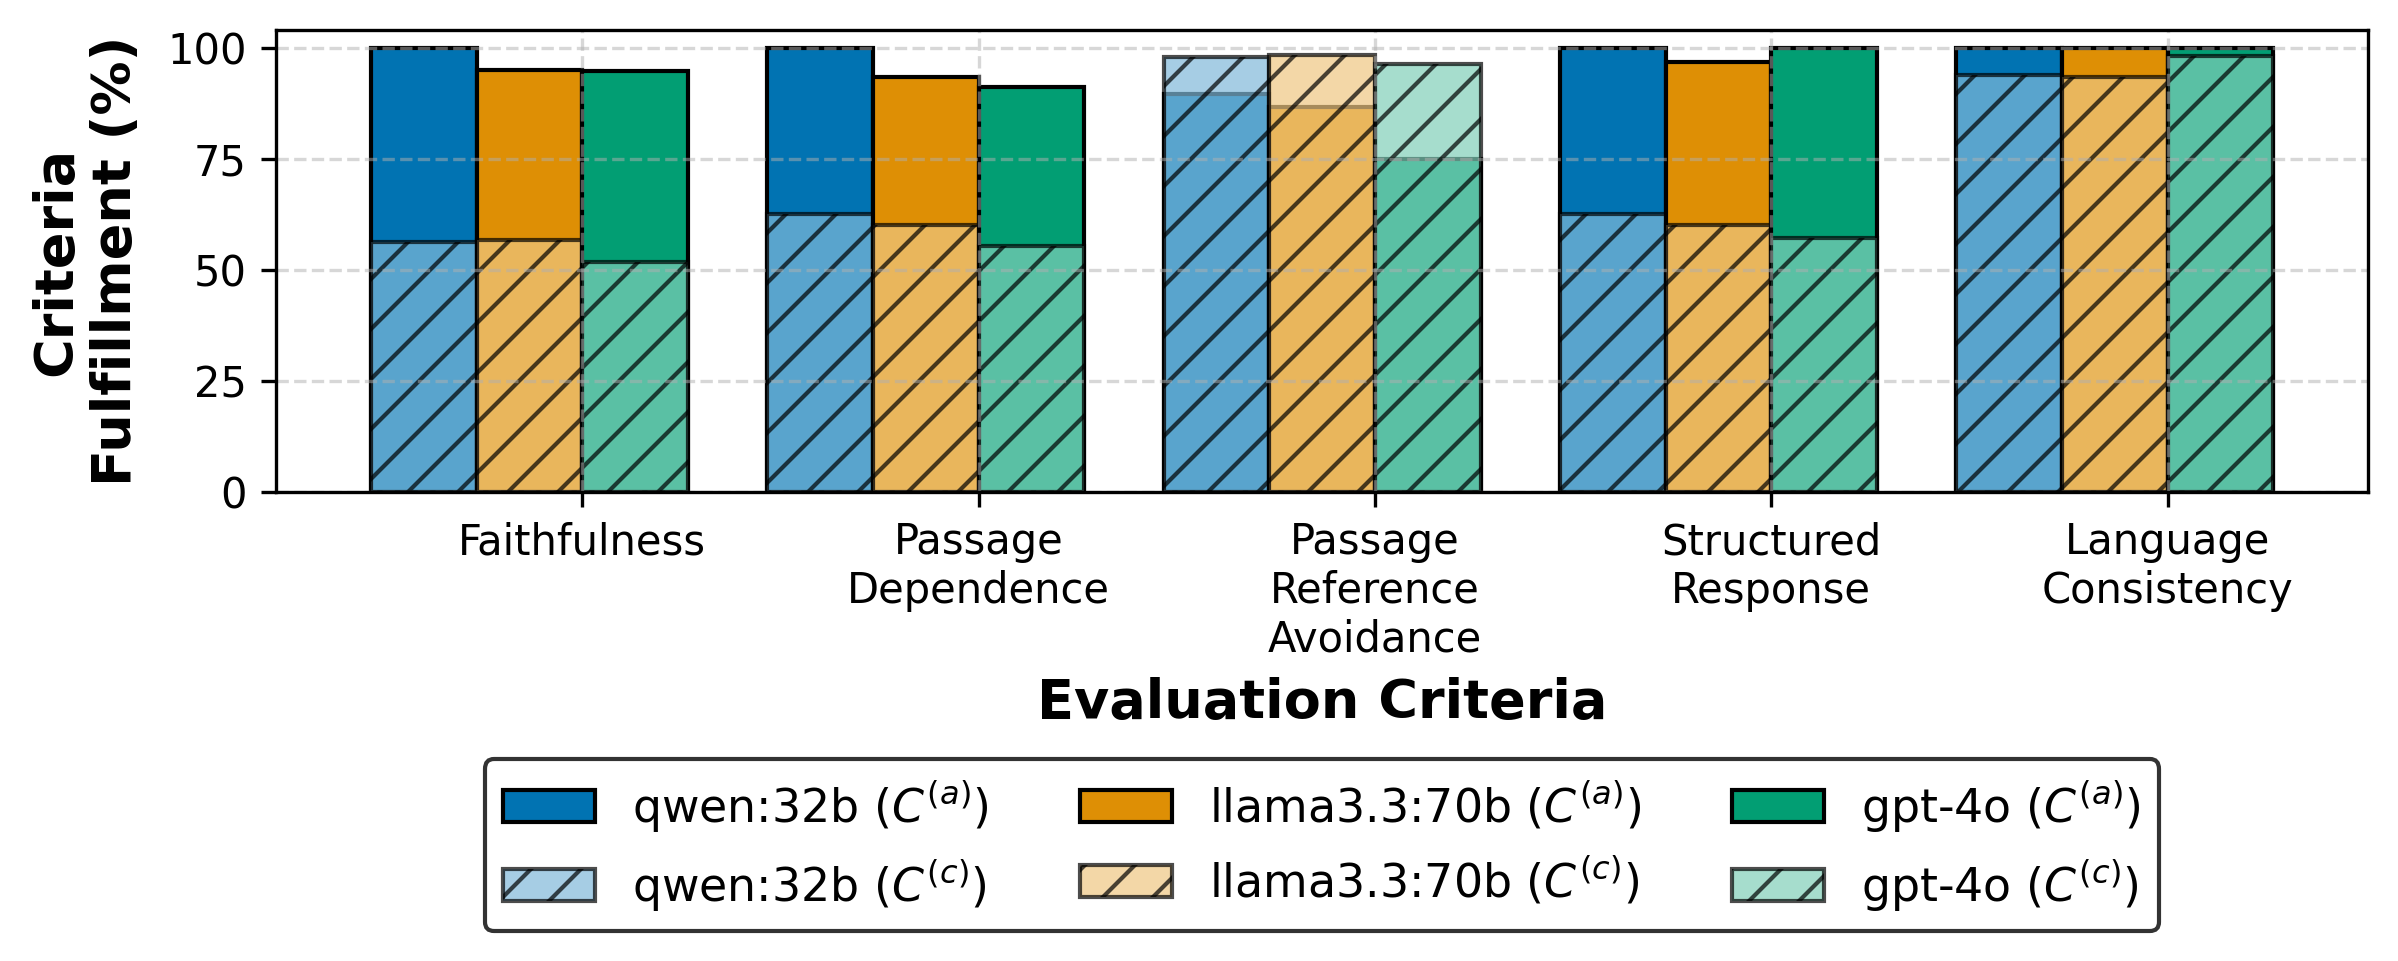

In [763]:
cols_eval = ["Faithfulness", "Passage Dependence", "Passage Reference Avoidance", "Structured Response", "Language Consistency"]

criteria_columns = []
for s in ["s", "t"]:
    for col in cols_eval:
        criteria_columns.append(f"{col}_{s}")

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# PART I
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
df1 = pd.read_excel("GENERATIONS/outs_good_model_tpc15/answers/annotated/Copy of all_models_eval_annotate_part1 - Alicia Joel.xlsx")
df1 = df1[df1.answer_t != "I cannot answer the question given the context."]
df1_ = pd.read_excel("GENERATIONS/outs_good_model_tpc15/answers/all_models_eval_annotate_part1 - Karla Cantarero (1).xlsx")
df1_ = df1_[df1_.answer_t != "I cannot answer given the context"]
df1 = df1.merge(df1_, on=["row_id"], suffixes=("_a1", "_a2"))
for col in cols_eval:
    df1[f"{col}_s"] = df1[[f"{col}_s_a1", f"{col}_s_a2"]].mean(axis=1)
    df1[f"{col}_t"] = df1[[f"{col}_t_a1", f"{col}_t_a2"]].mean(axis=1)

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# PART II
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
df2 = pd.read_excel("GENERATIONS/outs_good_model_tpc15/answers/VA_2_all_models_eval_annotate_part2 - Valerie Alanis Aldana Lainez.xlsx")
df2 = df2[df2.answer_t != "I cannot answer given the context"]
df2_ = pd.read_excel("GENERATIONS/outs_good_model_tpc15/answers/all_models_eval_annotate_part2 - John Oakley.xlsx")
df2_ = df2_[df2_.answer_t != "I cannot answer given the context"]
df2 = df2.merge(df2_, on=["row_id"], suffixes=("_a1", "_a2"))
for col in cols_eval:
    df2[f"{col}_s"] = df2[[f"{col}_s_a1", f"{col}_s_a2"]].mean(axis=1)
    df2[f"{col}_t"] = df2[[f"{col}_t_a1", f"{col}_t_a2"]].mean(axis=1)

df = pd.concat([df1,df2])

df_parts = pd.read_excel("GENERATIONS/outs_good_model_tpc15/answers/all_models_eval_annotate_part1_2_with_model_info.xlsx")
df = df.merge(df_parts[["row_id", "model"]], on="row_id", how="left")
df["model"] = df["model"].apply(lambda x: x.replace('gpt-4o-2024-08-06', 'gpt-4o'))

cols_plot = ["Faithfulness", "Passage Dependence", "Passage Reference Avoidance", "Structured Response", "Language Consistency"]

affected_cols = ["Opinion Awareness", "Passage Reference Avoidance", "Structured Response"]
models = ["qwen:32b", "llama3.3:70b", "gpt-4o"]  # Define the models

# Define colorblind-friendly Tableau 10 palette
colorblind_palette = sns.color_palette("colorblind", len(models))

# Prepare figure dynamically
fig, ax = plt.subplots(figsize=(max(9, 3 + 3 * 1.5), 2), dpi=300)
#plt.subplots(figsize=(max(9, 3 + len(models) * 1.5), 3), dpi=300)
# Define bar width dynamically
bar_width = max(0.15, 0.8 / len(models))
x = np.arange(len(cols_eval))  # X locations for groups

# Plot both source and target in one graph with different bar styles
bars = []
for i, (model, color) in enumerate(zip(models, colorblind_palette)):
    # Extract source and target data
    #df_filtered = df[~((df["answer_t"] == "I cannot answer the question given the context") & 
    #                   (df[[f"{col}_t" for col in affected_cols]].isna().any(axis=1)))]
    
    for col in cols_eval:
        df[f"{col}_t"] = pd.to_numeric(df[f"{col}_t"], errors="coerce")
        df[f"{col}_s"] = pd.to_numeric(df[f"{col}_s"], errors="coerce")  # Also convert source scores

    # Compute source and target data
    source_data = df.fillna(0).groupby("model")[[f"{col}_s" for col in cols_eval]].mean() * 100
    target_data = df.fillna(0).groupby("model")[[f"{col}_t" for col in cols_eval]].mean() * 100

    #target_data = source_data * 0.87

    # Transpose for easier plotting
    source_data = source_data.T
    target_data = target_data.T

    # Rename columns to remove suffixes for better alignment
    source_data.columns = target_data.columns = models

    # Crear un color más claro para el Target (interpolando con blanco)
    lighter_color = mcolors.to_rgba(color, alpha=1)  # Convertir a RGBA
    lighter_color = [(c + 1) / 2 for c in lighter_color[:3]] + [1]  # Aclarar color

    # Dibujar las barras del Source (sólidas)
    bars.append(ax.bar(x + i * bar_width, source_data[model], width=bar_width, 
                   label=rf"{model} ($C^{{(a)}}$)", color=color, edgecolor="black"))

    # Dibujar las barras del Target (mismo color pero más claro y con hatch en negro)
    bars.append(ax.bar(x + i * bar_width, target_data[model], width=bar_width, 
                   label=rf"{model} ($C^{{(c)}}$)", facecolor=lighter_color, edgecolor="black", hatch='//', alpha=0.7))

#
# Labels and title
ax.set_xlabel("Evaluation Criteria", fontsize=13, fontweight="bold", color="black")
ax.set_ylabel("Criteria\nFulfillment (%)", fontsize=13, fontweight="bold", color="black", labelpad=6)

# Set x-ticks and labels
ax.set_xticks(x + bar_width * (len(models) / 2))
formatted_labels = [textwrap.fill(label, width=13) for label in cols_plot]
ax.set_xticklabels(formatted_labels, fontsize=10, color="black", ha="center")

ax.set_ylim(0, 104)
ax.grid(True, linestyle="--", alpha=0.5)

# Make x and y axis borders black
for spine in ax.spines.values():
    spine.set_color("black")

# Move legend outside the plot
legend = ax.legend(fontsize=11, loc="lower center", bbox_to_anchor=(0.5, -1), ncol=len(models) * 2, ncols=3)
legend.get_frame().set_edgecolor("black")
# Save as high-resolution PDF
plt.savefig("/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/figures/answer_quality_evaluation.pdf", dpi=300, bbox_inches="tight")

# Show the figure
plt.show()

# FEVER-DPLACE-Q_v1

In [894]:
df.columns

Index(['claim', 'evidence', 'label', 'question', 'answer1', 'answer2',
       'discp_qwen:32b', 'reason_qwen:32b', 'discp_llama3.3:70b',
       'reason_llama3.3:70b', 'discp_gpt-4o-2024-08-06',
       'reason_gpt-4o-2024-08-06', 'discp_qwen2.5:32b', 'reason_qwen2.5:32b'],
      dtype='object')

In [2]:
df = pd.read_csv("_old_dont_remove/data_arr_feb/FEVER-DPLACE-Q_v2_discp.csv")
#df_ = pd.read_csv("/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/src/qa_system/FEVER-DPLACE-Q_v1_discp_qwen25.csv")
#df = pd.concat([df, df_])
columns_keep = ['claim', 'evidence', 'label', 'question', 'answer1', 'answer2']

#df[df.label == "REFUTES"] = "CONTRADICTION"
#df[df.label == "SUPPORTS"] = "NO_DISCREPANCY"
df[df["discp_gpt-4o-2024-08-06"] == '- DISCREPANCY_TYPE: NO'] = "NO_DISCREPANCY"

for model in ["qwen:32b", "llama3.3:70b", "gpt-4o-2024-08-06"]: #, "qwen2.5:32b"
    columns_keep.append(f"discp_{model}")
    df[f"discp_{model}"] = df[f"discp_{model}"].apply(lambda x : x.replace('TYPE: NOT_ENOUGH_INFO', 'NOT_ENOUGH_INFO'))
    print(df[f"discp_{model}"].unique())
    df[f"agree_{model}"] = df["label"] == df[f"discp_{model}"]

columns_eval = ["label"] + [col for col in df.columns if "agree" in col]
print(columns_eval)

['CULTURAL_DISCREPANCY' 'CONTRADICTION' 'NO_DISCREPANCY' 'NOT_ENOUGH_INFO']
['CULTURAL_DISCREPANCY' 'CONTRADICTION' 'NO_DISCREPANCY' 'NOT_ENOUGH_INFO']
['CULTURAL_DISCREPANCY' 'CONTRADICTION' 'NO_DISCREPANCY' 'NOT_ENOUGH_INFO']
['label', 'agree_qwen:32b', 'agree_llama3.3:70b', 'agree_gpt-4o-2024-08-06']


In [3]:
models = ["qwen:32b", "llama3.3:70b", "gpt-4o-2024-08-06"]
accuracy_results = []

for label in df["label"].unique():
    label_data = df[df["label"] == label]
    for model in models:
        accuracy = label_data[f"label"] == label_data[f"discp_{model}"]
        accuracy_results.append({"Label": label, "Model": model, "Accuracy": accuracy.mean()})

# Convert results to DataFrame
accuracy_df = pd.DataFrame(accuracy_results)

model_order = models
print(accuracy_df)
accuracy_df["Model"] = pd.Categorical(accuracy_df["Model"], categories=model_order, ordered=True)
latex_table = accuracy_df.pivot(index="Label", columns="Model", values="Accuracy")

latex_table = latex_table[model_order]

latex_output = latex_table.to_latex(float_format="%.3f")

print(latex_output)

                   Label              Model  Accuracy
0   CULTURAL_DISCREPANCY           qwen:32b  0.900000
1   CULTURAL_DISCREPANCY       llama3.3:70b  0.780000
2   CULTURAL_DISCREPANCY  gpt-4o-2024-08-06  0.780000
3        NOT_ENOUGH_INFO           qwen:32b  0.771429
4        NOT_ENOUGH_INFO       llama3.3:70b  0.514286
5        NOT_ENOUGH_INFO  gpt-4o-2024-08-06  0.542857
6          CONTRADICTION           qwen:32b  0.980000
7          CONTRADICTION       llama3.3:70b  0.980000
8          CONTRADICTION  gpt-4o-2024-08-06  0.980000
9         NO_DISCREPANCY           qwen:32b  0.960000
10        NO_DISCREPANCY       llama3.3:70b  0.960000
11        NO_DISCREPANCY  gpt-4o-2024-08-06  0.960000
\begin{tabular}{lrrr}
\toprule
Model & qwen:32b & llama3.3:70b & gpt-4o-2024-08-06 \\
Label &  &  &  \\
\midrule
CONTRADICTION & 0.980 & 0.980 & 0.980 \\
CULTURAL_DISCREPANCY & 0.900 & 0.780 & 0.780 \\
NOT_ENOUGH_INFO & 0.771 & 0.514 & 0.543 \\
NO_DISCREPANCY & 0.960 & 0.960 & 0.960 \\
\bottomrule

In [4]:
accuracy_df

,Label,Model,Accuracy
0,CULTURAL_DISCREPANCY,qwen:32b,0.900000
1,CULTURAL_DISCREPANCY,llama3.3:70b,0.780000
2,CULTURAL_DISCREPANCY,gpt-4o-2024-08-06,0.780000
3,NOT_ENOUGH_INFO,qwen:32b,0.771429
4,NOT_ENOUGH_INFO,llama3.3:70b,0.514286
5,NOT_ENOUGH_INFO,gpt-4o-2024-08-06,0.542857
6,CONTRADICTION,qwen:32b,0.980000
7,CONTRADICTION,llama3.3:70b,0.980000
8,CONTRADICTION,gpt-4o-2024-08-06,0.980000
9,NO_DISCREPANCY,qwen:32b,0.960000


In [7]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score

models = ["qwen:32b", "llama3.3:70b", "gpt-4o-2024-08-06"]
f1_results = []

for model in models:
    per_class_f1 = []
    
    for label in df["label"].unique():
        # Create binary labels (1 if this label, 0 otherwise)
        true_binary = (df["label"] == label).astype(int)
        pred_binary = (df[f"discp_{model}"] == label).astype(int)

        # Compute F1-score for this specific label
        f1 = f1_score(true_binary, pred_binary, average="binary")
        per_class_f1.append(f1)

        # Store per-class F1-score
        f1_results.append({"Label": label, "Model": model, "F1-score": f1})

    # Compute Weighted-F1 for the model
    weighted_f1 = f1_score(df["label"], df[f"discp_{model}"], average="weighted")
    f1_results.append({"Label": "Weighted-F1", "Model": model, "F1-score": weighted_f1})

# Convert results to DataFrame
f1_df = pd.DataFrame(f1_results)

# Sort models correctly
model_order = models
f1_df["Model"] = pd.Categorical(f1_df["Model"], categories=model_order, ordered=True)

# Pivot for LaTeX output
latex_table = f1_df.pivot(index="Label", columns="Model", values="F1-score")
latex_table = latex_table[model_order]  # Ensure correct column order

# Convert to LaTeX table
latex_output = latex_table.to_latex(float_format="%.3f", caption="F1-score per Label and Weighted-F1", label="tab:f1_scores")
print(latex_output)

\begin{table}
\caption{F1-score per Label and Weighted-F1}
\label{tab:f1_scores}
\begin{tabular}{lrrr}
\toprule
Model & qwen:32b & llama3.3:70b & gpt-4o-2024-08-06 \\
Label &  &  &  \\
\midrule
CONTRADICTION & 0.925 & 0.845 & 0.852 \\
CULTURAL_DISCREPANCY & 0.882 & 0.804 & 0.848 \\
NOT_ENOUGH_INFO & 0.857 & 0.679 & 0.704 \\
NO_DISCREPANCY & 0.970 & 0.923 & 0.881 \\
Weighted-F1 & 0.913 & 0.824 & 0.831 \\
\bottomrule
\end{tabular}
\end{table}



In [115]:
df.columns

Index(['claim', 'evidence', 'label', 'question', 'answer1', 'answer2',
       'discp_qwen:32b', 'reason_qwen:32b', 'discp_llama3.3:70b',
       'reason_llama3.3:70b', 'discp_gpt-4o-2024-08-06',
       'reason_gpt-4o-2024-08-06', 'agree_qwen:32b', 'agree_llama3.3:70b',
       'agree_gpt-4o-2024-08-06'],
      dtype='object')

/tmp/ipykernel_3510286/639025056.py:66: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(bottom=0.25)


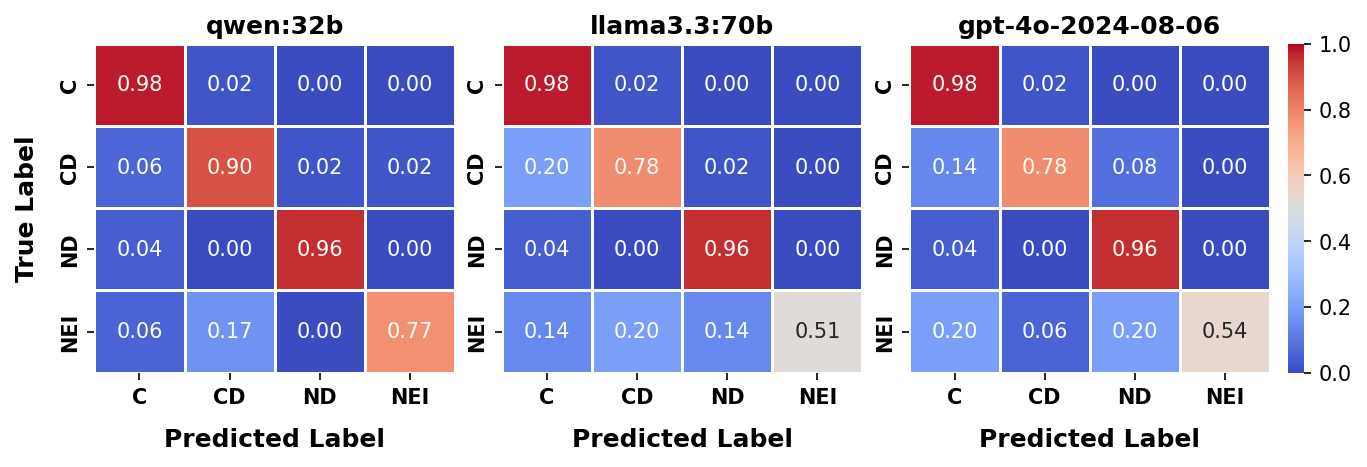

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

# Load data
df = pd.read_csv("_old_dont_remove/data_arr_feb/FEVER-DPLACE-Q_v2_discp.csv")

# Standardize label names
df.loc[df["discp_gpt-4o-2024-08-06"] == '- DISCREPANCY_TYPE: NO', "discp_gpt-4o-2024-08-06"] = "NO_DISCREPANCY"

# Define models
models = ["qwen:32b", "llama3.3:70b", "gpt-4o-2024-08-06"]

label_mapping = {
    "CONTRADICTION": "C",
    "CULTURAL_DISCREPANCY": "CD",
    "NOT_ENOUGH_INFO": "NEI",
    "NO_DISCREPANCY": "ND",
    "REFUTES": "C",  # Just in case older labels exist
    "SUPPORTS": "ND",
    "TYPE: NOT_ENOUGH_INFO": "NEI"
}

# Apply label mapping to true labels and model predictions
df["label"] = df["label"].replace(label_mapping)
for model in models:
    df[f"discp_{model}"] = df[f"discp_{model}"].replace(label_mapping)

# Apply label mapping
df["label"] = df["label"].replace(label_mapping)
for model in models:
    df[f"discp_{model}"] = df[f"discp_{model}"].replace(label_mapping)

# Extract unique labels
all_labels = sorted(set(df["label"]).union(*[set(df[f"discp_{model}"]) for model in models]))

# Function to wrap labels
def wrap_labels(labels, width=10):
    return [textwrap.fill(label, width) for label in labels]

# Create subplots
fig, axes = plt.subplots(1, len(models), figsize=(9, 3), dpi=150, constrained_layout=True)

for i, model in enumerate(models):
    # Compute confusion matrix
    cm = pd.crosstab(df["label"], df[f"discp_{model}"], normalize="index").reindex(index=all_labels, columns=all_labels, fill_value=0)

    # Plot heatmap
    ax = axes[i]
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5,
                xticklabels=wrap_labels(cm.columns), yticklabels=wrap_labels(cm.index),
                ax=ax, cbar=(i == len(models)-1), vmin=0, vmax=1)

    ax.set_title(f"{model}", fontsize=12, fontweight="bold", pad=5)
    ax.set_xlabel("Predicted Label", fontsize=12, fontweight="bold", labelpad=10)
    ax.set_ylabel("True Label" if i == 0 else "", fontsize=12, fontweight="bold", labelpad=10)

    # Format tick labels
    ax.tick_params(axis="x", rotation=0, labelsize=10)  
    ax.tick_params(axis="y", labelsize=10)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontsize(10)
        label.set_fontweight("bold")

plt.subplots_adjust(bottom=0.25)
plt.savefig("confusion_fever_d_place_q_fixed.pdf", dpi=300, bbox_inches="tight")
plt.show()


## STATISTICS

In [9]:
import pandas as pd
import numpy as np
import ast

# List of Excel file paths
excels = [
    "_old_dont_remove/data_arr_feb/GENERATIONS/outs_good_model_tpc11/questions_queries/questions_topic_11_qwen:32b_100_seed_1234.xlsx",
    "_old_dont_remove/data_arr_feb/GENERATIONS/outs_good_model_tpc11/questions_queries/questions_topic_11_llama3.3:70b_100_seed_1234.xlsx",
    "_old_dont_remove/data_arr_feb/GENERATIONS/outs_good_model_tpc11/questions_queries/questions_topic_11_gpt-4o-2024-08-06_100_seed_1234.xlsx"
]

# Dictionary to store results
summary_data = []

# Process each Excel file
for excel in excels:
    # Read the Excel file
    df = pd.read_excel(excel)
    
    # Calculate lengths
    df["question_len"] = df["question"].apply(lambda x: len(x.split()))
    df["queries_len"] = df["queries"].apply(lambda row: np.mean([len(x.split()) for x in ast.literal_eval(row)]))
    df["queries_nr"] = df["queries"].apply(lambda row: len(ast.literal_eval(row)))

    # Compute statistics
    model_name = excel.split("/")[-1]  # Extracting model name from the path
    summary_data.append({
        "Model": model_name,
        "Total Items": len(df),
        "Question Length (Mean ± Std)": f"{df['question_len'].mean():.2f} ± {df['question_len'].std():.2f}",
        "Number of Queries (Mean ± Std)": f"{df['queries_nr'].mean():.2f} ± {df['queries_nr'].std():.2f}",
        "Queries Length (Mean ± Std)": f"{df['queries_len'].mean():.2f} ± {df['queries_len'].std():.2f}",
    })

# Convert to DataFrame
summary_df = pd.DataFrame(summary_data)
latex_table = summary_df.to_latex(index=False, column_format="|l|c|c|c|c|", caption="Summary Statistics", label="tab:summary")
print(latex_table)

\begin{table}
\caption{Summary Statistics}
\label{tab:summary}
\begin{tabular}{|l|c|c|c|c|}
\toprule
Model & Total Items & Question Length (Mean ± Std) & Number of Queries (Mean ± Std) & Queries Length (Mean ± Std) \\
\midrule
questions_topic_11_qwen:32b_100_seed_1234.xlsx & 237 & 16.03 ± 4.74 & 2.43 ± 0.83 & 6.59 ± 1.77 \\
questions_topic_11_llama3.3:70b_100_seed_1234.xlsx & 396 & 16.51 ± 5.53 & 2.30 ± 0.64 & 7.98 ± 3.44 \\
questions_topic_11_gpt-4o-2024-08-06_100_seed_1234.xlsx & 297 & 15.93 ± 4.98 & 2.02 ± 0.13 & 7.51 ± 1.59 \\
\bottomrule
\end{tabular}
\end{table}



# DISCREPANCIES

In [ ]:
df = pd.read_parquet("_old_dont_remove/data_arr_feb/GENERATIONS/outs_good_model_tpc15/answers/all_models_eval_v2.parquet")
df.model.unique()

array(['qwen:32b', 'llama3.3:70b'], dtype=object)

In [613]:
raw = pd.read_parquet("/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/data/source/corpus_rosie/passages/26_jan/df_1.parquet")

In [689]:
raw[(raw.doc_id.str.contains("ES")) & raw.text.str.contains("SIDS")]["text"]

33871                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   Tabaquismo o consumo de tabaco: En general, el consumo de tabaco afecta el apetito de la mujer y el sabor de muchos alimentos. Es conveniente evitar el consumo de tabaco durante la lactancia o

In [677]:
#raw[raw.text.str.contains("hasta los 12 meses con un riesgo significativamente menor de transmisión del VIH")]

In [733]:
raw["original_doc_id"] = raw["doc_id"].apply(lambda x: x.split("-")[0])
print(len(list(set(raw[raw.original_doc_id.str.contains("EN")].original_doc_id.values.tolist()))))
print(len(list(set(raw[raw.original_doc_id.str.contains("ES")].original_doc_id.values.tolist()))))

542055
333175


In [724]:
df_fever = pd.read_csv("FEVER-DPLACE-Q_v2_discp.csv")
df_fever[df_fever.label=="CULTURAL_DISCREPANCY"]

,claim,evidence,label,question,answer1,answer2,discp_qwen:32b,reason_qwen:32b,discp_llama3.3:70b,reason_llama3.3:70b,discp_gpt-4o-2024-08-06,reason_gpt-4o-2024-08-06
0,Floor level of the prevailing type of dwelling.,"['Subterranean or semi-subterranean, ignoring cellars beneath the living quarters', 'Floor formed by or level with the ground itself']",CULTURAL_DISCREPANCY,Is the primary living space typically located above ground level?,"No, it is often subterranean or semi-subterranean, excluding cellars.","Yes, it is typically at ground level.",CULTURAL_DISCREPANCY,"The answers reflect differences in cultural practices and norms regarding the location of primary living spaces, rather than factual contradictions.",CULTURAL_DISCREPANCY,"The answers reflect differences that can stem from various architectural traditions, geographical considerations, and cultural preferences regarding the location of primary living spaces. For instance, some cultures or regions might favor subterranean or semi-subterranean dwellings due to climate, available materials, or historical practices, while others might build at ground level for different reasons. These variations do not necessarily represent a direct factual contradiction but rather differences in common practices or traditions that can depend on the cultural context.",CULTURAL_DISCREPANCY,"The answers reflect differences in cultural practices and norms regarding the location of primary living spaces. In some cultures or regions, living spaces may be designed to be subterranean or semi-subterranean for reasons such as climate control or tradition, while in others, living spaces are typically at ground level. These differences stem from cultural norms rather than factual contradictions."
1,Age or occupational specialization in the gathering of wild plants and small land fauna.,"['Junior age specialization, i.e., the activity is largely performed by boys and/or girls before the age of puberty', 'Senior age specialization, i.e., the activity is largely performed by men and/or women beyond the prime of life']",CULTURAL_DISCREPANCY,Is the gathering of wild plants and small land fauna typically performed by older adults?,"No, it is primarily carried out by boys and girls before puberty.","Yes, it is mainly done by older adults beyond their prime.",CULTURAL_DISCREPANCY,"The answers reflect differences in cultural practices and norms regarding who gathers wild plants and small land fauna, rather than factual contradictions. They suggest that age groups involved in this activity may vary across societies.",CULTURAL_DISCREPANCY,"The answers provide directly opposing information regarding who typically gathers wild plants and small land fauna, with one stating it's primarily children before puberty and the other claiming it's mainly older adults. However, considering the context of different cultures or societies, it's possible that in some communities, this task might indeed be performed by younger individuals as part of their learning and contribution to the family or community, while in others, it could be a role reserved for or taken on by older adults due to their experience, knowledge, or physical capability. This discrepancy reflects differences that can stem from cultural norms, values, or societal perspectives rather than being a direct factual contradiction applicable universally.",CULTURAL_DISCREPANCY,"The answers reflect differences in cultural practices and norms regarding who typically gathers wild plants and small land fauna. In some cultures, this task may be assigned to children, while in others, it may be the responsibility of older adults. These variations are based on societal roles and expectations rather than factual contradictions."
2,"Following the inheritance rule for movable property, this variable indicates how movable property is distributed among several individuals of the same category. [Note that Murdock (1963a) warned that the codes for this variable had ""proved in

In [626]:
paths_ = [
    #"/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/src/qa_system/GENERATIONS/outs_good_model_tpc11/answers/all_models_eval_v6.parquet",
    #"/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/src/qa_system/GENERATIONS/outs_good_model_tpc15/answers/all_models_eval_v6.parquet"
    "GENERATIONS/outs_good_model_tpc15/answers/questions_topic_15_qwen:32b_100_seed_1234_results_model30tpc_thr__dynamic.parquet",
    "GENERATIONS/outs_good_model_tpc15/answers/questions_topic_15_gpt-4o-2024-08-06_100_seed_1234_results_model30tpc_thr__dynamic.parquet",
    "GENERATIONS/outs_good_model_tpc15/answers/questions_topic_15_llama3.3:70b_100_seed_1234_results_model30tpc_thr__dynamic.parquet",
    "GENERATIONS/outs_good_model_tpc11/answers/questions_topic_11_qwen:32b_100_seed_1234_results_model30tpc_thr__dynamic.parquet",
    "GENERATIONS/outs_good_model_tpc11/answers/questions_topic_11_llama3.3:70b_100_seed_1234_results_model30tpc_thr__dynamic.parquet",
    "GENERATIONS/outs_good_model_tpc11/answers/questions_topic_11_gpt-4o-2024-08-06_100_seed_1234_results_model30tpc_thr__dynamic.parquet",
]

all_disc = []

# Process original datasets
for path in paths_:
    df = pd.read_parquet(path)
    #print(len(df))
    df = df[~df.question.str.contains("Here are the YES/NO questions generated based on the PASSAGE:")]
    #print(len(df))

    if "gpt" in path:
        df["model"] = "gpt-4o"
    elif "llama" in path: 
        df["model"] = "llama3.3:70b"
    else:
        df["model"] = "qwen:32b"

    # Fix discrepancy values
    df.loc[df['answer_t'].str.contains("cannot answer the question given the context", na=False), 'discrepancy'] = "NOT_ENOUGH_INFO"
    df.loc[df["answer_t"] == "I cannot answer given the context.", ["discrepancy"]] = "NOT_ENOUGH_INFO"
    df["discrepancy"] = df["discrepancy"].str.replace("NO_ DISCREPANCY", "NO_DISCREPANCY")
    df["discrepancy"] = df["discrepancy"].str.replace("CULTURAL_ DISCREPANCY", "CULTURAL_DISCREPANCY")

    # Add source column
    df["source"] = path.split("_tpc")[-1].split("/")[0]

    # Keep only relevant rows
    df_filtered = df[df["discrepancy"].isin(["CONTRADICTION", "CULTURAL_DISCREPANCY"])]

    # Sample 25 rows with NO_DISCREPANCY
    no_discrepancy_sample = df[df["discrepancy"] == "NO_DISCREPANCY"].groupby("model", group_keys=False).sample(n=10, random_state=42)
    print(len(no_discrepancy_sample))

    # Concatenate filtered results
    df_final = pd.concat([df_filtered, no_discrepancy_sample], ignore_index=True)

    # Keep only necessary columns
    df_final = df_final[["question", "answer_t", "answer_s", "discrepancy", "source", "model", "reason"]]

    # Append to all_disc
    all_disc.append(df_final)

# Load FEVER-DPLACE-Q dataset
df_fever = pd.read_csv("FEVER-DPLACE-Q_v2_discp.csv")

# Sample 25 rows per unique label
#fever_samples = df_fever.groupby("label", group_keys=False).apply(lambda x: x.sample(n=min(30, len(x)), random_state=42))

# Rename columns
fever_samples = df_fever.copy()
fever_samples = fever_samples.rename(columns={"answer1": "answer_t", "answer2": "answer_s", "label": "discrepancy"})
fever_samples["model"] = "synthetic"
fever_samples["reason"] = "synthetic"
fever_samples["source"] = "FEVER-DPLACE-Q"
fever_samples["discrepancy"] = fever_samples["discrepancy"].str.replace("SUPPORTS", "NO_DISCREPANCY")
fever_samples["discrepancy"] = fever_samples["discrepancy"].str.replace("REFUTES", "CONTRADICTION")

# Keep only necessary columns
fever_samples = fever_samples[["question", "answer_t", "answer_s", "discrepancy", "source", "model", "reason"]]

# Append FEVER-DPLACE-Q sampled data to all_disc
all_disc.append(fever_samples)

# Create final dataframe
final_df = pd.concat(all_disc, ignore_index=True)
final_df = final_df.sample(frac=1, random_state=42).reset_index(drop=True)
final_df["id_discr"] = range(len(final_df))

final_df = final_df[['id_discr','source','question', 'answer_t', 'answer_s', 'discrepancy', 'model', 'reason']]
final_df["label"] = [""] * len(final_df)
final_df = final_df.drop_duplicates(subset="question", keep="first").reset_index(drop=True)

final_df.to_excel("GENERATIONS/discrepancies_v4.xlsx")
final_df.drop(columns=["source", "model", "discrepancy", "reason"]).to_excel("GENERATIONS/discrepancies_v4_users.xlsx", index=False)

10
10
10
10
10
10


In [627]:
print(len(final_df))
df_summary = final_df.value_counts(["model", "discrepancy"]).reset_index(name="count")
df_summary

257


,model,discrepancy,count
0,synthetic,NO_DISCREPANCY,50
1,synthetic,CULTURAL_DISCREPANCY,50
2,synthetic,CONTRADICTION,50
3,synthetic,NOT_ENOUGH_INFO,34
4,llama3.3:70b,NO_DISCREPANCY,19
5,gpt-4o,NO_DISCREPANCY,18
6,qwen:32b,NO_DISCREPANCY,18
7,llama3.3:70b,CONTRADICTION,8
8,qwen:32b,CULTURAL_DISCREPANCY,5
9,qwen:32b,CONTRADICTION,5


In [11]:
df_ann

,id_discr,question,answer_t,answer_s,Label
0,0,Can women breast-feed an infant while taking t...,"YES, women can breast-feed an infant while tak...","NO, women should not breast-feed an infant whi...",CONTRADICTION
1,1,Are there culturally significant deviations fr...,"Yes, there is an avunculocal pattern, where re...","Yes, there is an ambilocal pattern, where resi...",CULTURAL_DISCREPANCY
2,2,Can a positive fetal fibronectin test only sug...,"YES, a positive fetal fibronectin test can sug...","YES, a positive fetal fibronectin test only su...",NO_DISCREPANCY
3,3,Is the creation of earthenware utensils typica...,"No, it is primarily done by boys and girls bef...","Yes, it is mainly performed by older adults be...",CULTURAL_DISCREPANCY
4,4,Was The Messenger nominated?,"Yes, The Messenger was nominated.","Yes, The Messenger received nominations, inclu...",NO_DISCREPANCY
...,...,...,...,...,...
252,264,Is the typical ground plan of dwellings circul...,"No, it is often semicircular.","Yes, it is typically circular.",CULTURAL_DISCREPANCY
253,265,Can invasive candidiasis lead to death?,"YES, invasive candidiasis can lead to death. I...","YES, invasive candidiasis can lead to death.",NO_DISCREPANCY
254,266,Does The Proposal star an actor?,"Yes, The Proposal stars an actor.","Yes, The Proposal stars actors including Sandr...",NO_DISCREPANCY
255,268,Is metalworking involving fire typically perfo...,"No, it is primarily carried out by boys and gi...","Yes, it is mainly done by older adults beyond ...",CULTURAL_DISCREPANCY


In [5]:
df = pd.read_excel("_old_dont_remove/data_arr_feb/GENERATIONS/discrepancies_v4.xlsx")
#print(df.columns)

#############
#df_ann = pd.read_excel("GENERATIONS/Copy 3 of discrepancies_v4_users - Kieran Ryan.xlsx")
#df_ann["label"] = df_ann["label"].replace("Contradiction", "CONTRADICTION")
#df_ann["label"] = df_ann["label"].replace("Cultural_discrepancy", "CULTURAL_DISCREPANCY")
#df_ann["label"] = df_ann["label"].replace("No-Discrepancy", "NO_DISCREPANCY")
#df_ann["label"] = df_ann["label"].replace("No_Discrepancy", "NO_DISCREPANCY")
#
#
#df_ann=pd.read_excel("GENERATIONS/discrepancies_v4_users_anonymous.xlsx")
df_ann=pd.read_excel("_old_dont_remove/data_arr_feb/GENERATIONS/discrepancies_v4_users - ALONSO MADROÑAL DE MESA.xlsx")
df_ann["label"] = df_ann["Label"]
df_ann["label"] = df_ann["label"].replace("Contradiction", "CONTRADICTION")
df_ann["label"] = df_ann["label"].replace("Cultural_Discrepancy", "CULTURAL_DISCREPANCY")
df_ann["label"] = df_ann["label"].replace("No_Discrepancy", "NO_DISCREPANCY")
df_ann["label"] = df_ann["label"].replace("No_discrepancy", "NO_DISCREPANCY")
df_ann["label"] = df_ann["label"].replace("No_dicrepancies", "NO_DISCREPANCY")
df_ann["label"] = df_ann["label"].replace("Not_Enough_Info", "NOT_ENOUGH_INFO")
print(df_ann.label.unique())
print(f"number of CONTRADICTION: {len(df_ann[df_ann.label == 'CONTRADICTION'])/len(df_ann)}")
print(f"number of NO_DISCREPANCY: {len(df_ann[df_ann.label == 'NO_DISCREPANCY'])/len(df_ann)}")
print(f"number of CULTURAL_DISCREPANCY: {len(df_ann[df_ann.label == 'CULTURAL_DISCREPANCY'])/len(df_ann)}")
#############

df_ann2 = pd.read_excel("_old_dont_remove/data_arr_feb/GENERATIONS//discrepancies_v4_users_pat.xlsx")
df_ann2["label2"] = df_ann2["label"]
df_ann = df_ann.merge(df_ann2[["id_discr", "label2"]], on="id_discr", how="left")

df_ann = df_ann.merge(df[["id_discr", "model", "discrepancy", "reason"]], on="id_discr", how="left")
df_ann["model"] = df_ann["model"].fillna("synthetic")
df_ann["model"] = df_ann["model"].apply(lambda x: x.replace('gpt-4o-2024-08-06', 'gpt-4o'))
df_ann["agree"] = df_ann["label"] == df_ann["discrepancy"]
df_ann["agree2"] = df_ann["label2"] == df_ann["discrepancy"]
keep_cols = [col for col in df_ann if not col.startswith("Unnamed")]
df_ann = df_ann[keep_cols]

df_summary = df_ann.groupby(["model", "discrepancy"]).agg(
    agree_count=("agree", "sum"),    # Count of agreements (True values) for agree
    agree2_count=("agree2", "sum"),  # Count of agreements (True values) for agree2
    total=("agree", "count")         # Total number of rows in the group
).reset_index()

# Compute the proportion of agreements for both agree and agree2
df_summary["agree_ratio"] = df_summary["agree_count"] / df_summary["total"]
df_summary["agree2_ratio"] = df_summary["agree2_count"] / df_summary["total"]

df_summary

['CONTRADICTION' 'CULTURAL_DISCREPANCY' 'NO_DISCREPANCY' 'NOT_ENOUGH_INFO']
number of CONTRADICTION: 0.2490272373540856
number of NO_DISCREPANCY: 0.42412451361867703
number of CULTURAL_DISCREPANCY: 0.1828793774319066


,model,discrepancy,agree_count,agree2_count,total,agree_ratio,agree2_ratio
0,gpt-4o,NO_DISCREPANCY,18,18,18,1.000000,1.000000
1,llama3.3:70b,CONTRADICTION,7,6,8,0.875000,0.750000
2,llama3.3:70b,NO_DISCREPANCY,17,19,19,0.894737,1.000000
3,qwen:32b,CONTRADICTION,2,4,5,0.400000,0.800000
4,qwen:32b,CULTURAL_DISCREPANCY,0,2,5,0.000000,0.400000
5,qwen:32b,NO_DISCREPANCY,17,15,18,0.944444,0.833333
6,synthetic,CONTRADICTION,49,45,50,0.980000,0.900000
7,synthetic,CULTURAL_DISCREPANCY,44,48,50,0.880000,0.960000
8,synthetic,NOT_ENOUGH_INFO,32,33,34,0.941176,0.970588
9,synthetic,NO_DISCREPANCY,49,47,50,0.980000,0.940000


In [410]:
#df_ann[(df_ann.discrepancy =="NO_DISCREPANCY") & (df_ann.model=="qwen:32b") & (df_ann.agree2==False)]

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import cohen_kappa_score, f1_score
from krippendorff import alpha

# Compute Inter-Annotator Agreement
inter_annotator_kappa = cohen_kappa_score(df_ann["label"], df_ann["label2"])

# Convert categorical labels to numerical for Krippendorff’s Alpha
label_values = df_ann[["label", "label2"]].apply(lambda x: pd.factorize(x)[0])  # Encode categorical labels
inter_annotator_alpha = alpha(reliability_data=label_values.T.values, level_of_measurement="nominal")

# Store inter-annotator results
inter_annotator_results = pd.DataFrame([{
    "metric": "Inter-Annotator Kappa",
    "value": inter_annotator_kappa
}, {
    "metric": "Krippendorff Alpha",
    "value": inter_annotator_alpha
}])

# Group Model Agreement by Model and Category
agreement_results = []

for (model, category), group in df_ann.groupby(["model", "discrepancy"]):
    # Compute F1-score for model agreement
    f1_label = f1_score(group["label"], group["discrepancy"], average="weighted")
    f1_label2 = f1_score(group["label2"], group["discrepancy"], average="weighted")

    # Append results
    agreement_results.append({
        "model": model,
        "category": category,
        "f1_label": f1_label,
        "f1_label2": f1_label2
    })

# Convert results to DataFrame
agreement_by_category_df = pd.DataFrame(agreement_results)

In [8]:
inter_annotator_results

,metric,value
0,Inter-Annotator Kappa,0.846610
1,Krippendorff Alpha,-0.099661


In [10]:
agreement_by_category_df.groupby("category").agg(
    f1_label_mean=("f1_label", "mean"),
    f1_label2_mean=("f1_label2", "mean")
).reset_index()

,category,f1_label_mean,f1_label2_mean
0,CONTRADICTION,0.671780,0.735533
1,CULTURAL_DISCREPANCY,0.411915,0.584490
2,NOT_ENOUGH_INFO,0.912656,0.956102
3,NO_DISCREPANCY,0.933148,0.917126


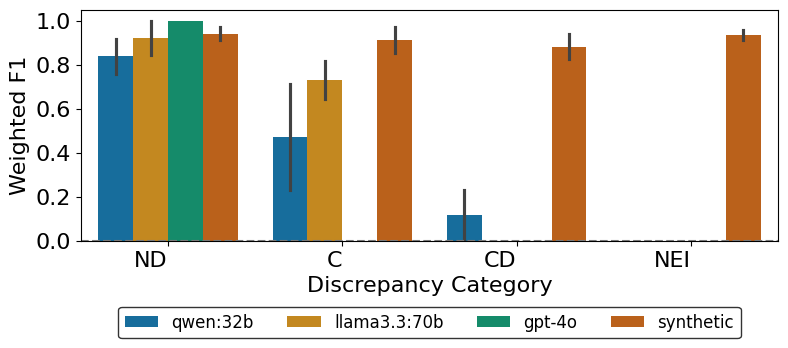

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define category labels
category_labels = {
    "NO_DISCREPANCY": "ND",
    "CONTRADICTION": "C",
    "CULTURAL_DISCREPANCY": "CD",
    "NOT_ENOUGH_INFO": "NEI"
}

# Replace category names in the dataframe
agreement_by_category_df["category"] = agreement_by_category_df["category"].replace(category_labels)

# Define the desired model order
model_order = ["qwen:32b", "llama3.3:70b", "gpt-4o", "FEVER-DPLACE-Q"]

# Ensure all models in the data are included, even if not in model_order
all_models = agreement_by_category_df["model"].unique()
full_model_order = [m for m in model_order if m in all_models] + [m for m in all_models if m not in model_order]

# Convert the 'model' column to categorical with the specified order
agreement_by_category_df["model"] = pd.Categorical(agreement_by_category_df["model"], categories=full_model_order, ordered=True)

# --- Adjusted Clustered Bar Chart: F1-score per Model and Category (Sorted) ---
plt.figure(figsize=(9, 3))

ax = sns.barplot(
    data=agreement_by_category_df.melt(id_vars=["model", "category"], value_vars=["f1_label", "f1_label2"]),
    x="category", y="value", hue="model", palette="colorblind", hue_order=full_model_order  # Ensure correct order
)

plt.axhline(0, linestyle="--", color="gray")  # Baseline
plt.xlabel("Discrepancy Category", fontsize=16)
plt.ylabel("Weighted F1", fontsize=16)
#plt.title("Model Agreement (F1-score) Across Categories", fontsize=16)
plt.xticks(rotation=0, ha="right", fontsize=16)  # Improve readability
plt.yticks(rotation=0, fontsize=16)  # Improve readability

# Adjust legend to be at the bottom in one row with a black border
legend = plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.25), ncol=4, frameon=True, fontsize=12)
legend.get_frame().set_edgecolor("black")  # Set black border for the legend

plt.savefig("/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/figures/discrepancy_evaluation.pdf", dpi=300, bbox_inches="tight")

plt.show()

In [13]:
agreement_by_category_df

,model,category,f1_label,f1_label2
0,gpt-4o,ND,1.000000,1.000000
1,llama3.3:70b,C,0.816667,0.642857
2,llama3.3:70b,ND,0.845029,1.000000
3,qwen:32b,C,0.228571,0.711111
4,qwen:32b,CD,0.000000,0.228571
5,qwen:32b,ND,0.917460,0.757576
6,synthetic,C,0.970101,0.852632
7,synthetic,CD,0.823830,0.940408
8,synthetic,NEI,0.912656,0.956102
9,synthetic,ND,0.970101,0.910928


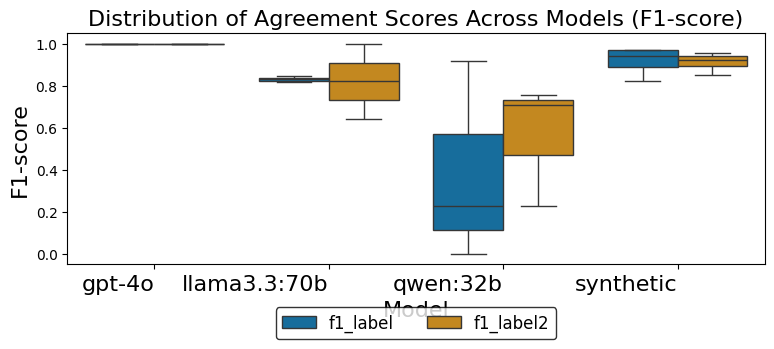

In [11]:
# --- Adjusted Boxplot: Distribution of F1-scores Across Models ---
plt.figure(figsize=(9, 3))
ax = sns.boxplot(data=agreement_by_category_df.melt(id_vars="model", value_vars=["f1_label", "f1_label2"]), 
                 x="model", y="value", hue="variable", palette="colorblind")

plt.xlabel("Model", fontsize=16)
plt.ylabel("F1-score", fontsize=16)
plt.title("Distribution of Agreement Scores Across Models (F1-score)", fontsize=16)
plt.xticks(rotation=0, ha="right", fontsize=16)  # Improve readability

# Adjust legend to be at the bottom in one column with a black border
legend = plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=1, frameon=True, fontsize=12, ncols=4)
legend.get_frame().set_edgecolor("black")  # Set black border for the legend

plt.show()

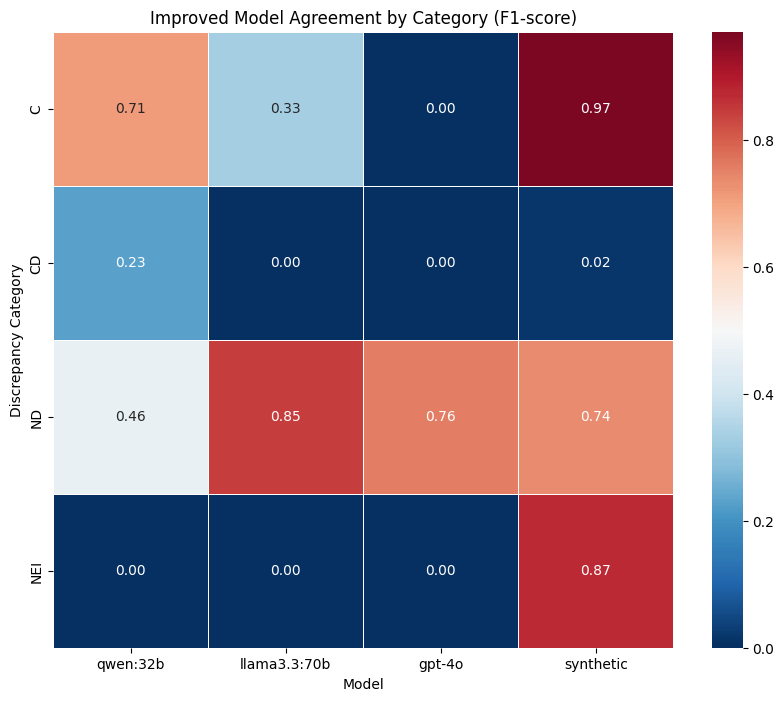

In [573]:
# --- Improved Heatmap: F1-score per Model and Category (Uniform Grid) ---
# Pivot the dataframe to ensure all models and categories are represented
heatmap_data = agreement_by_category_df.pivot(index="category", columns="model", values="f1_label").fillna(0)

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="RdBu_r", linewidths=0.5, center=0.5, fmt=".2f")

plt.xlabel("Model")
plt.ylabel("Discrepancy Category")
plt.title("Improved Model Agreement by Category (F1-score)")
plt.show()

## Preparing topic 24

In [80]:
df = pd.read_excel("/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/src/qa_system/GENERATIONS/outs_good_model_tpc24/questions_queries/questions_topic_24_qwen:32b_100.xlsx")

In [85]:
df.head(100).to_excel("/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/src/qa_system/GENERATIONS/outs_good_model_tpc24/question_queries_100/questions_topic_24_qwen:32b_100.xlsx")

## Intermediate

In [241]:
df = pd.read_excel("GENERATIONS/outs_good_model_tpc24/questions_queries/questions_topic_15_qwen:32b_23400.xlsx")

In [242]:
df_filtered = df.dropna(subset=['queries'])
print(len(df_filtered))
print(len(df))
df_filtered.to_excel("GENERATIONS/outs_good_model_tpc15_complete/question_queries/questions_topic_15_qwen:32b_23400.xlsx")

23401
29362


In [243]:
df = pd.read_excel("GENERATIONS/outs_good_model_tpc24/questions_queries/questions_topic_24_qwen:32b_18900.xlsx")

In [244]:
df_filtered = df.dropna(subset=['queries'])
print(len(df_filtered))
print(len(df))
df_filtered.to_excel("GENERATIONS/outs_good_model_tpc24_complete/question_queries/questions_topic_24_qwen:32b_18900.xlsx")

18901
34211


In [245]:
df = pd.read_excel("GENERATIONS/outs_good_model_tpc24/questions_queries/questions_topic_11_qwen:32b_14300.xlsx")
df_filtered.loc[df_filtered["question"] == "especially those under 15 years old?", ["question"]] = "Is there a higher risk of low birthweight for teenage mothers, especially those under 15 years old?"
df_filtered.loc[df_filtered["question"] == "Does having a baby at a younger age increase the risk of low birthweight? Is there a higher risk of low birthweight for teenage mothers", ["question"]] = "Does having a baby at a younger age increase the risk of low birthweight?"

In [247]:
df_filtered = df.dropna(subset=['queries'])
print(len(df_filtered))
print(len(df))
df_filtered.to_excel("GENERATIONS/outs_good_model_tpc11_complete/questions_queries/questions_topic_11_qwen:32b_14300.xlsx")

14301
39750


In [267]:
df = pd.read_parquet("/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/src/qa_system/GENERATIONS/outs_good_model_tpc15_complete/answers/questions_topic_15_qwen:32b_23400_results_model30tpc_thr_dynamic_combined_to_retrieve_relevant copy.parquet")

In [766]:
paths_final = [
    "GENERATIONS/outs_good_model_tpc15_complete/answers/questions_topic_15_qwen:32b_23400_results_model30tpc_thr__dynamic.parquet",
    "GENERATIONS/outs_good_model_tpc11_complete/answers/questions_topic_11_qwen:32b_14300_results_model30tpc_thr__dynamic.parquet",
    "GENERATIONS/outs_good_model_tpc24_complete/answers/questions_topic_24_qwen:32b_18900_results_model30tpc_thr__dynamic.parquet",
]

all_ = []
for path in paths_final:
    df = pd.read_parquet(path)
    tpc= path.split("_tpc")[-1].split("_")[0]
    df["topic"]=tpc

    # cleaning 
    df.loc[df['answer_t'].str.contains("cannot answer the question given the context", na=False), 'discrepancy'] = "NOT_ENOUGH_INFO"
    df.loc[df["answer_t"] == "I cannot answer given the context.", ["discrepancy"]] = "NOT_ENOUGH_INFO"
    df.loc[df["discrepancy"] == "TYPE: NO_", ["discrepancy"]] = "NO_DISCREPANCY"
    df.loc[df["discrepancy"] == "DISCREPANCY_ TYPE: CULTURAL_ DISCREPANCY", ["discrepancy"]] = "CULTURAL_DISCREPANCY"
    df.loc[df["discrepancy"] == "CULTURAL_DISCREPANCY (if we consider that slight variations in recommendations might exist due to cultural influences or different parenting practices, though it's a weak case for this category)", ["discrepancy"]] = "CULTURAL_DISCREPANCY"
    df.loc[df["discrepancy"] == "DISCREPANCY_TYPE: NO_ DISCREPANCY", ["discrepancy"]] = "NO_DISCREPANCY"
    df.loc[df["discrepancy"] == "TYPE: CULTURAL_", ["discrepancy"]] = "CULTURAL_DISCREPANCY"
    df.loc[df["discrepancy"] == "DISCREPANCY_ TYPE: NO_ DISCREPANCY", ["discrepancy"]] = "NO_DISCREPANCY"
    df.loc[df["discrepancy"] == "DISCREPANCY_ TYPE: NO DISCREPANCY", ["discrepancy"]] = "NO_DISCREPANCY"
    df["discrepancy"] = df["discrepancy"].str.replace("NO_ DISCREPANCY", "NO_DISCREPANCY")
    df["discrepancy"] = df["discrepancy"].str.replace("NO_ENOUGH_INFO", "NOT_ENOUGH_INFO")
    df["discrepancy"] = df["discrepancy"].str.replace("CULTURAL_ DISCREPANCY", "CULTURAL_DISCREPANCY")
    
    all_.append(df)

df = pd.concat(all_)
print(df.discrepancy.unique())
len(df)

['NOT_ENOUGH_INFO' 'NO_DISCREPANCY' 'CULTURAL_DISCREPANCY' ''
 'CONTRADICTION' 'NO_' 'NO DISCREPANCY' 'NO_ONGOING_DISCREPANCY'
 'TYPE: NOT_ENOUGH_INFO' 'NO_NEGATIVE_EFFECTS'
 'CULTURAL_DISCREPANCY (if you consider the slight difference in number of exposures as stemming from different studies or expert opinions)']


258500

In [765]:
df_keep = df[df.discrepancy != "NOT_ENOUGH_INFO"].copy()
df_keep = df[df.discrepancy != "NO_DISCREPANCY"].copy()
#df_keep = df.copy()
df_keep["question_id"] =df_keep.apply(lambda x: "TPC_" + str(x["question_id"]) + "_" + str(x["question_id"]), axis=1)
df_keep = df_keep.drop_duplicates(subset=['question', 'answer_s', 'answer_t'], keep='first')
df_keep = df_keep.reset_index(drop=True)
print(len(df_keep))

category_order = ['CONTRADICTION', 'CULTURAL_DISCREPANCY', 'NO_DISCREPANCY']


# Convert the column to a categorical type with the specified order

df_keep['discrepancy'] = pd.Categorical(df_keep['discrepancy'], categories=category_order, ordered=True)

df_v1 = pd.concat([pd.read_excel("ROSIE_MIND/rosie_mind_v4_disc.xlsx"), pd.read_excel("ROSIE_MIND/rosie_mind_v3_disc.xlsx"), pd.read_excel("ROSIE_MIND/rosie_mind_v2_disc.xlsx"), pd.read_excel("ROSIE_MIND/rosie_mind_v1.xlsx")])
df_keep = df_keep[~df_keep["question_id"].isin(df_v1["question_id"])]

# Sort by the categorical column
df_sorted = df_keep.sort_values(by='discrepancy')
df_sorted["final_label"] = len(df_sorted) * [""]
print("FINAL LENGHT: ", len(df_sorted))
#df_sorted.to_excel("ROSIE_MIND/rosie_mind_v5_disc.xlsx")

14392
FINAL LENGHT:  3506


In [652]:
final_rosie = pd.read_excel("/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/src/qa_system/ROSIE_MIND/final_rosie_mind_v1.xlsx")
final_rosie = final_rosie[['question_id', 'question', 'passage_s', 'answer_s','passage_t', 'answer_t', 'reason', 'final_label']]

In [ ]:
latex_table = final_rosie.to_latex(index=False, escape=True, caption="Your Table Caption", label="tab:your_table", longtable=True)

print(latex_table)

In [ ]:
df = pd.read_excel("/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/src/qa_system/GENERATIONS/outs_good_model_tpc11_complete/questions_queries/questions_topic_11_qwen:32b_14300.xlsx")


In [698]:
import re
def extend_to_full_sentence(text: str, num_words: int) -> str:
    text_in_words = text.split()
    truncated_text = " ".join(text_in_words[:num_words])
    remaining_text = " ".join(text_in_words[num_words:])
    period_index = remaining_text.find(".")
    if period_index != -1:
        extended_text = f"{truncated_text} {remaining_text[:period_index + 1]}"
    else:
        extended_text = truncated_text
    return re.sub(r'\s([?.!,"])', r'\1', extended_text)

In [716]:
example = df[df.question.str.contains("Can hydramnios be caused by issues related to both the mother and the baby?")]
extend_to_full_sentence(example.full_doc.values[0], 100)

'Hydramnios What is hydramnios? In this condition, there is too much amniotic fluid around your baby during pregnancy. It happens in about 1 in 100 pregnancies. It’s also called polyhydramnios. Your baby needs amniotic fluid to grow. This watery fluid is inside the amniotic sac (membrane). It’s sometimes called the bag of waters. Your baby stays in this fluid for all of pregnancy. It helps to cushion and protect your baby. Amniotic fluid also helps your baby’s lungs, kidneys, and gastrointestinal tract grow. The fluid is made by your baby’s lungs and kidneys. Your baby swallows the fluid and passes it out as urine.'

In [719]:
df["len"] = df["passage"].apply(lambda x: len(x.split()))
df[df.len < 20][["question", "passage"]].head(50)
df[df.question.str.contains("Can hydramnios be caused by issues related to both the mother and the baby?")][["question", "passage","queries"]]

,question,passage,queries
784,Can hydramnios be caused by issues related to both the mother and the baby?,It can be caused by problems in both the mother and baby.,"['""hydramnios causes maternal factors', ' hydramnios causes fetal factors""']"
4156,Can hydramnios be caused by issues related to both the mother and the baby?,Key points about hydramnios:\n- Hydramnios occurs when there’s too much amniotic fluid around your baby during pregnancy.\n- It can be caused by problems in both the mother and baby.\n- It causes the uterus to grow fast.\n- Your healthcare provider may spot this condition during an ultrasound in pregnancy.\n- Treatment will depend on the amount of extra fluid you have. It will also depend on other factors.,"['""hydramnios causes', ' maternal factors for hydramnios', ' fetal factors for hydramnios""']"
